# Analyzing the quality of NEIMS predictions

We want to know wether the NEIMS intensity prediction is any good. 

zadani: mrknout se, jestli poradi podle velikosti na spektru z NISTu a vygenerovanyho NEIMS spektra sedi "aspon polovina z prvnich dvaceti" (ales)

In [4]:
pip install spectrum-utils

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
from matchms.importing import load_from_msp
from matchms.filtering import normalize_intensities

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from rdkit.Chem import PandasTools
from pandas import DataFrame as df
from rdkit import Chem
from rdkit.Chem.inchi import MolToInchiKey

import os
import spectrum_utils.plot as sup
import spectrum_utils.spectrum as sus
from collections import Counter
import random

### Loading the data

#### NEIMS test Smiles to enriched SDF

In [3]:
def filter_corrupted_smiles(pp):
    for index, row in pp.iterrows():
#         print(row[2])
        try:
            mol = Chem.Mol(row[2])
        except:
            pp.drop(index, inplace=True)
#     print("after filtering corrupted molecules:", len(pp))
    return pp
            
whole_test_path = "../NEIMS/training_splits/test_set_smiles.txt"
tmp_smiles_path = "../NEIMS/tmp/tmp_smiles.txt"
sdf_before = "/home/adam/Desktop/InternetExplorer/Skola/Spektro/NEIMS/tmp/tmp_before.sdf"
sdf_after = "/home/adam/Desktop/InternetExplorer/Skola/Spektro/NEIMS/tmp/tmp_after.sdf"
size = 11600

model_weights = "../NEIMS/NEIMS_weights"
with open(whole_test_path, "r") as test_f, open(tmp_smiles_path, "w") as tmp_smiles:
    np.random.seed(42)
    data = test_f.readlines()
    r_arr = np.random.choice(np.arange(0, len(data)), replace=False, size=size)
    r_smiles = np.unique(np.array([data[i] for i in r_arr]))
    # r_smiles = filter_corrupted_smiles(r_smiles) 
    r_id_smiles = list(zip(r_arr, r_smiles))    
    smiles_to_w = "".join(["\t".join([str(x),y]) for x,y in r_id_smiles])
    tmp_smiles.write(smiles_to_w)

pp = pd.read_csv(tmp_smiles_path, names=['id', 'smiles'], sep="\t") 
PandasTools.AddMoleculeColumnToFrame(pp, smilesCol='smiles', molCol='ROMol')
pp = pp.assign(inchikey=lambda x: [MolToInchiKey(mol) for mol in x["ROMol"]])#.set_index("ID")
pp = filter_corrupted_smiles(pp)

# filter pp to unique according to inchikey
pp = pp.drop_duplicates(subset=["inchikey"])

PandasTools.WriteSDF(pp, sdf_before, idName="id", properties=list(pp.columns))

print(f"now run in terminal:\n###############\nconda activate NEIMSpy2 && bash /home/adam/Desktop/InternetExplorer/Skola/Spektro/NEIMS/run_make_spectra_prediction.sh {sdf_before} {sdf_after} && conda deactivate\n###############\n")

[17:13:14] Conflicting single bond directions around double bond at index 1.
[17:13:14]   BondStereo set to STEREONONE and single bond directions set to NONE.
[17:13:15] Conflicting single bond directions around double bond at index 4.
[17:13:15]   BondStereo set to STEREONONE and single bond directions set to NONE.


OSError: File error: Bad output file /home/adam/Desktop/InternetExplorer/Skola/Spektro/NEIMS/tmp/tmp_before.sdf

,id,smiles,ROMol,inchikey
0,10576,BrCc1ccc(Br)cc1,,YLRBJYMANQKEAW-UHFFFAOYSA-N
1,3646,BrP(c1ccccc1)(c1ccccc1)(c1ccccc1)C1CC1,,NCCHCKHTFAHGMJ-UHFFFAOYSA-N
2,3031,Brc1ccc(Oc2c(Br)cc(Br)cc2Br)c(Br)c1,,NSKIRYMHNFTRLR-UHFFFAOYSA-N
3,9848,Brc1ccccc1CCc1ccccc1Br,,CVGGCYQDKJYOCA-UHFFFAOYSA-N
4,2582,C#CC(C)(C)O,,CEBKHWWANWSNTI-UHFFFAOYSA-N
...,...,...,...,...
995,1643,c1ccc2c(c1)NCCCCCNc1ccccc1OCCSCCO2,,VYSBHBNDEWLQLH-UHFFFAOYSA-N
996,1272,c1ccc2c(c1)cc1ccc3cc4ccccc4c4ccc2c1c34,,TUGYIJVAYAHHHM-UHFFFAOYSA-N
997,10414,c1ccc2c(c1)ccc1nc3ccc4ccccc4c3cc12,,ANUCHZVCBDOPOX-UHFFFAOYSA-N
998,8899,c1ccc2c(c1)ccc1nc3ccccc3nc12,,SEXRCKWGFSXUOO-UHFFFAOYSA-N

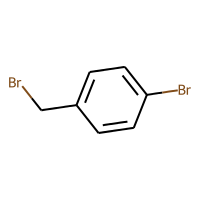
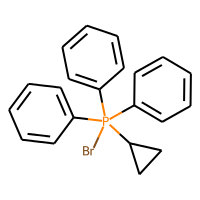
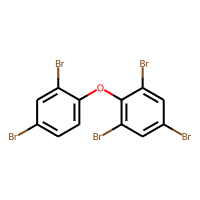
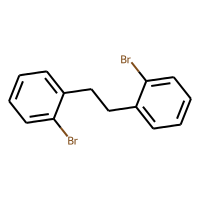
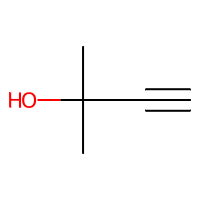
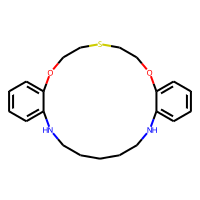
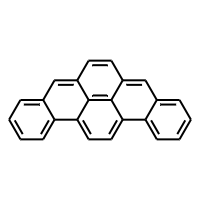
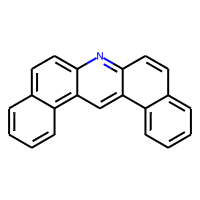
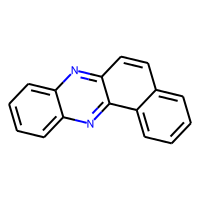
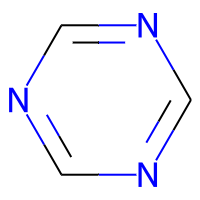

In [3]:
pp

In [4]:
# neims_test_path = "../NEIMS/testdata/test_14_mend_all_valid.sdf"
neims_test_path = "../NEIMS/tmp/tmp_after.sdf"
nist_path = "../data/20210925_NIST_EI_MS_cleaned.msp"

In [5]:
%%time
nist = [*load_from_msp(nist_path)]

CPU times: user 1min 45s, sys: 672 ms, total: 1min 45s
Wall time: 1min 45s


In [10]:
nist[33].metadata

{'name': 'Methyl Alcohol',
 'formula': 'CH4O',
 'mw': '32',
 'casno': '67-56-1',
 'id': '34',
 'comment': 'SemiStdNP=354/16/10 StdNP=379/7/34 StdPolar=903/8/35 ; NIST MS# 18836, Seq# R728',
 'inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3',
 'inchikey': 'OKKJLVBELUTLKV-UHFFFAOYSA-N',
 'iupac_name': 'methanol',
 'smiles': 'CO',
 'num peaks': '16'}

In [11]:
neims_test = PandasTools.LoadSDF(neims_test_path, idName="ID", smilesName='Smiles', molColName='Molecule')

In [30]:
len(neims_test)

926

In [13]:
%%time
# get NIST ids of molecules in the test set
def get_nist_spec_match(key):
    neims_ids = neims_test[key].tolist()
#     print(neims_ids)
    ids = []
    no_inchi = []
    counter = 0
    for i, x in enumerate(nist):
        try:
#             print( nist[i].metadata[key])
            id_ = nist[i].metadata[key]
            if id_ in neims_ids:
                counter += 1
                ids.append((i, id_))
                neims_ids.remove(id_)
                
        except:
            no_inchi.append(i)
    print("matched ids: ", counter, "/", counter+len(neims_ids))
    return sorted(ids), no_inchi
        
key = "inchikey"
ids, no_inchi = get_nist_spec_match(key) 

ids = ids
len(neims_test)
~neims_test.inchikey.isin([y for x,y in ids])
neims_test.drop(neims_test[~neims_test.inchikey.isin([y for x,y in ids])].index, inplace=True)
len(neims_test)
neims_test = neims_test.assign(nist_idMINUS1=lambda x : [i for inch in x[key] for i,k in ids if inch==k])

matched ids:  926 / 1000
CPU times: user 2.03 s, sys: 6.21 ms, total: 2.04 s
Wall time: 2.04 s


In [34]:
nist[10].metadata

{'name': 'Acetylene',
 'formula': 'C2H2',
 'mw': '26',
 'casno': '74-86-2',
 'id': '11',
 'ri': '198',
 'comment': 'SemiStdNP=157/1/6 StdNP=165/10/7 ; NIST MS# 18811, Seq# R31 |RI:198|',
 'inchi': 'InChI=1S/C2H2/c1-2/h1-2H',
 'inchikey': 'HSFWRNGVRCDJHI-UHFFFAOYSA-N',
 'iupac_name': 'acetylene',
 'smiles': 'C#C',
 'num peaks': '8'}

In [14]:
# !ls
# path="nist_test_smiles.txt"
# with open(path, "w+") as f:
#     for id_, t in enumerate(neims_test.smiles):
#         f.write(str(ids[id_][1]) + "\t" + t + "\n")

In [32]:
# collect original NIST spectra and generated spectra by NEIMS
nist_test_spec = {id_[0]: {"smiles": nist[id_[0]].metadata["smiles"], 
                           "inchikey": nist[id_[0]].metadata["inchikey"],
                           "mz": nist[id_[0]].peaks.mz.astype(int),
                           "intensity": nist[id_[0]].peaks.intensities/max(nist[id_[0]].peaks.intensities)} for id_ in ids}

# nist_test_spec

,smiles,inchikey,PREDICTED SPECTRUM,ID,Smiles,Molecule,nist_idMINUS1
0,BrCc1ccc(Br)cc1,YLRBJYMANQKEAW-UHFFFAOYSA-N,14 9\n15 17\n17 10\n18 40\n25 24\n26 91\n27 22...,10576,BrCc1ccc(Br)cc1,,133671
2,Brc1ccc(Oc2c(Br)cc(Br)cc2Br)c(Br)c1,NSKIRYMHNFTRLR-UHFFFAOYSA-N,36 9\n37 37\n39 3\n44 13\n45 12\n49 62\n50 171...,3031,Brc1ccc(Oc2c(Br)cc(Br)cc2Br)c(Br)c1,,344444
3,Brc1ccccc1CCc1ccccc1Br,CVGGCYQDKJYOCA-UHFFFAOYSA-N,26 16\n27 47\n28 30\n37 48\n38 141\n39 240\n40...,9848,Brc1ccccc1CCc1ccccc1Br,,245359
4,C#CC(C)(C)O,CEBKHWWANWSNTI-UHFFFAOYSA-N,14 76\n15 176\n16 18\n17 6\n18 21\n19 11\n25 3...,2582,C#CC(C)(C)O,,1608
5,C#CCBr,YORCIIVHUBAYBQ-UHFFFAOYSA-N,14 34\n25 120\n26 215\n28 10\n31 39\n36 121\n3...,7191,C#CCBr,,9780
...,...,...,...,...,...,...,...
995,c1ccc2c(c1)NCCCCCNc1ccccc1OCCSCCO2,VYSBHBNDEWLQLH-UHFFFAOYSA-N,27 23\n38 23\n39 126\n40 121\n41 255\n42 136\n...,1643,c1ccc2c(c1)NCCCCCNc1ccccc1OCCSCCO2,,281175
996,c1ccc2c(c1)cc1ccc3cc4ccccc4c4ccc2c1c34,TUGYIJVAYAHHHM-UHFFFAOYSA-N,26 27\n27 45\n36 7\n38 11\n39 74\n40 55\n41 6\...,1272,c1ccc2c(c1)cc1ccc3cc4ccccc4c4ccc2c1c34,,202466
997,c1ccc2c(c1)ccc1nc3ccc4ccccc4c3cc12,ANUCHZVCBDOPOX-UHFFFAOYSA-N,27 8\n36 1\n38 2\n39 84\n40 21\n41 3\n44 0\n50...,10414,c1ccc2c(c1)ccc1nc3ccc4ccccc4c3cc12,,172304
998,c1ccc2c(c1)ccc1nc3ccccc3nc12,SEXRCKWGFSXUOO-UHFFFAOYSA-N,38 23\n39 116\n40 40\n41 14\n44 22\n50 127\n51...,8899,c1ccc2c(c1)ccc1nc3ccccc3nc12,,111770

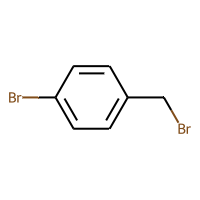
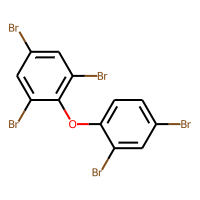
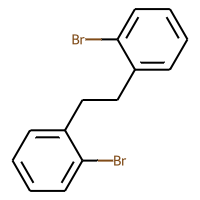
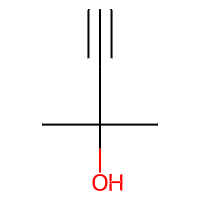
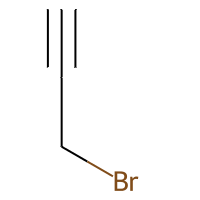
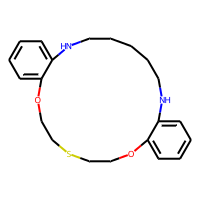
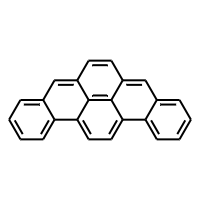
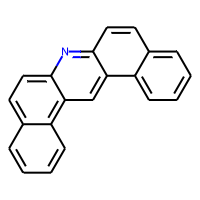
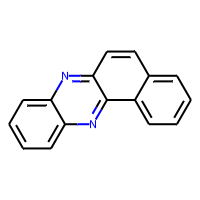
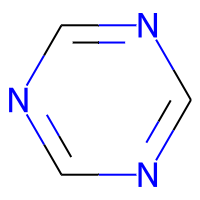

In [19]:
# extract and prepare NEIMS predicted test spectra

# out_file = f"/home/adam/Desktop/InternetExplorer/Skola/Spektro/NEIMS/tmp/tmp_after.sdf"

# frame = PandasTools.LoadSDF(out_file, smilesName='SMILES', molColName='Molecule')
neims_test
# neims_test_spec = [(f.split("\n"), smiles) for f, smiles in frame["PREDICTED SPECTRUM", "SMILES"]]

In [20]:
def process_neims_spec(spec, smiles):
    spec = spec.split("\n")
    i = []
    mz = []
    for t in spec:
        j,d = t.split()
        mz.append(j)
        i.append(d)
    return {"smiles": smiles, "mz": np.array(mz).astype(int), "intensity": np.array(i).astype(float)/max(np.array(i).astype(float))}

neims_test_spec = {}
for i, ps in neims_test.sort_values(by=['nist_idMINUS1'])[["nist_idMINUS1", "PREDICTED SPECTRUM", "smiles"]].iterrows():
    neims_test_spec[int(ps["nist_idMINUS1"])] = process_neims_spec(ps["PREDICTED SPECTRUM"], ps["smiles"])
#     print(psneims_test_spec[ps["ID"]] = ["PREDICTED SPECTRUM"])
#     print("--")
# neims_test_spec

In [23]:
print(neims_test_spec.keys() == nist_test_spec.keys())
print(len(nist_test_spec.keys()))
print(len(neims_test_spec.keys()))

True
926
926


## Spectra visualization

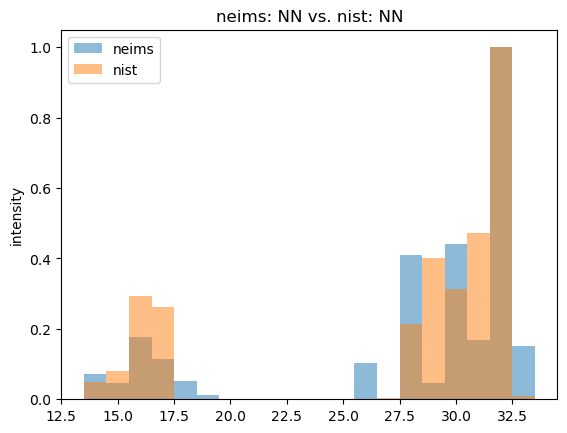

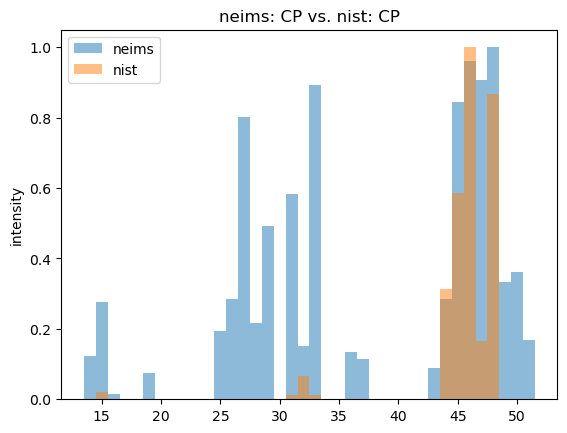

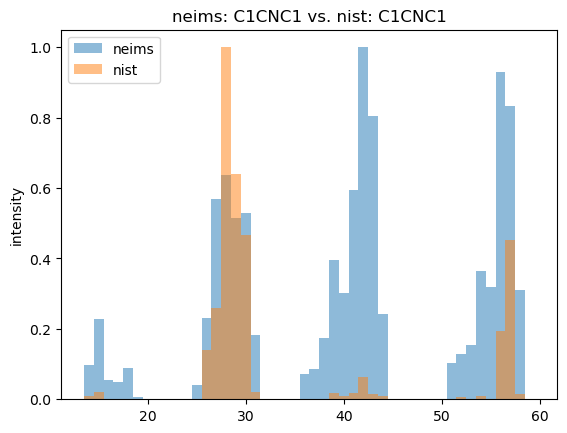

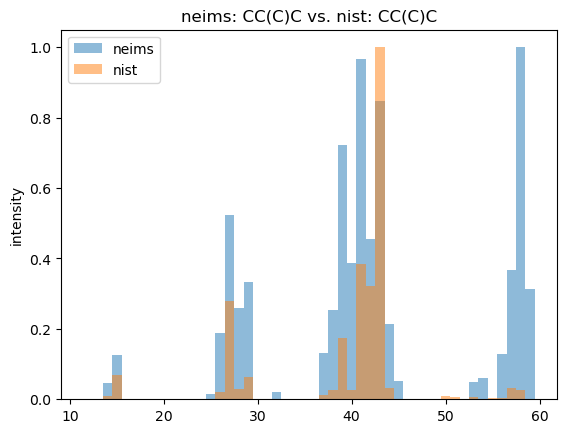

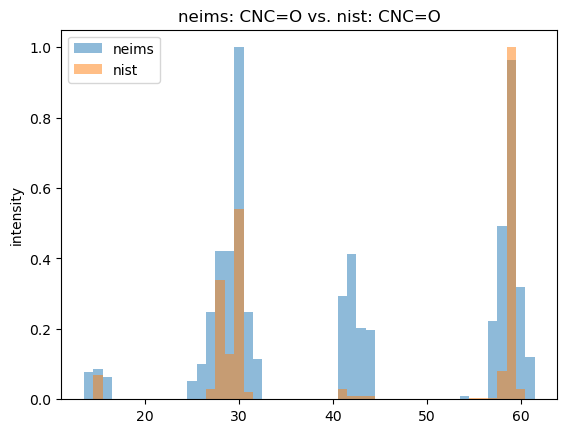

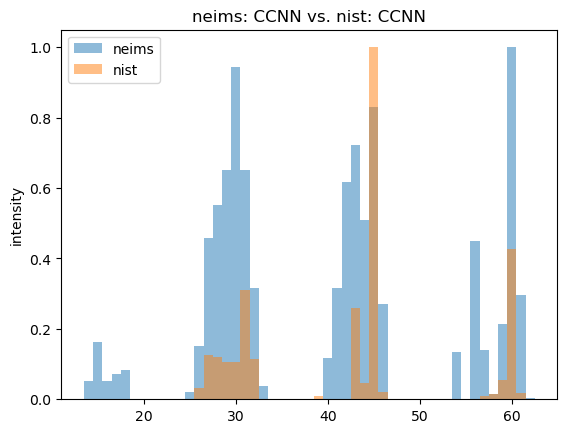

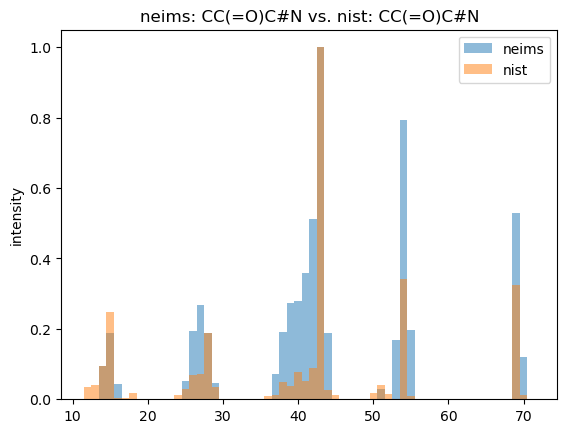

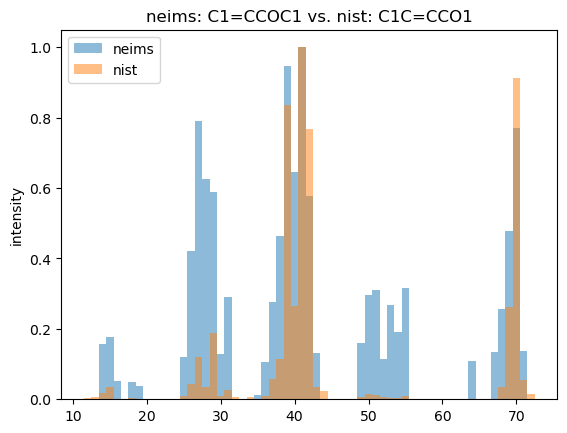

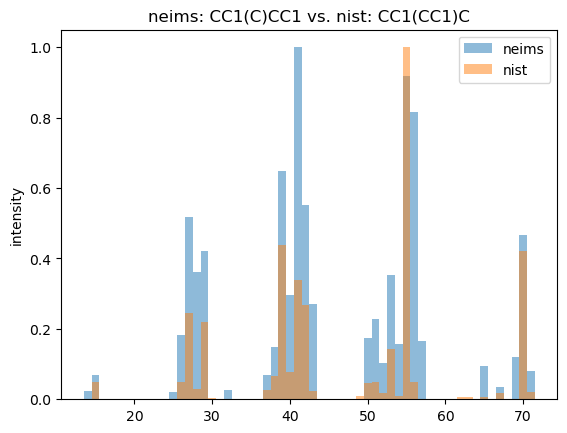

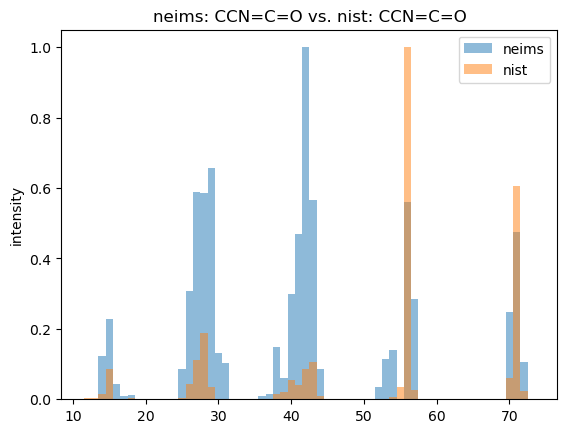

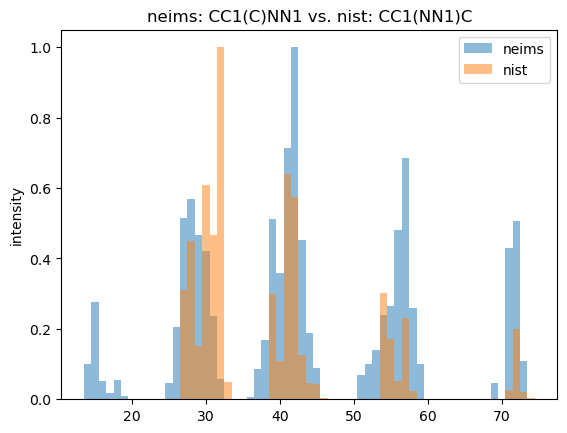

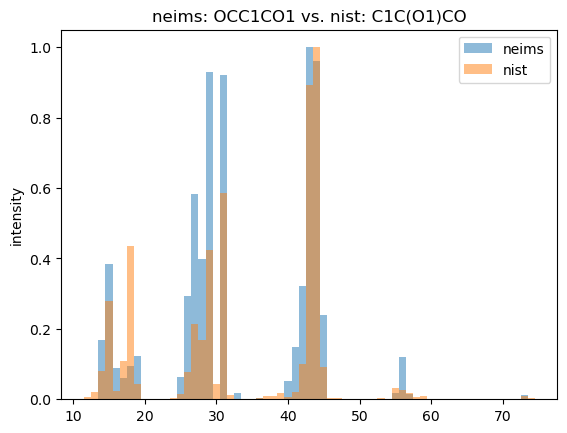

KeyboardInterrupt: 

In [24]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

def visualize_two_spectra(neims_spec, nist_spec):
    fig, ax = plt.subplots()
    ax.bar(neims_spec["mz"], height=neims_spec["intensity"], width=1, align='center', alpha=0.5, label="neims") #blue
    ax.bar(nist_spec["mz"], height=nist_spec["intensity"], width=1, align='center', alpha=0.5, label="nist") #orange
    # ax.xticks(y_pos, objects)
    ax.set_ylabel('intensity')
    ax.set_title(f'neims: {neims_spec["smiles"]} vs. nist: {nist_spec["smiles"]}')
    ax.legend()
    plt.show()

def visualize_two_spectra_1array(neims_arr, nist_arr):
    fig, ax = plt.subplots()
    ax.bar(range(len(neims_arr)), height=neims_arr, width=1, align='center', alpha=0.5, label="neims") #blue
    ax.bar(range(len(nist_arr)), height=nist_arr, width=1, align='center', alpha=0.5, label="nist") #orange
    # ax.xticks(y_pos, objects)
    ax.set_ylabel('intensity')
    ax.legend(["NEIMS", "NIST"])
#     ax.set_title(f'neims: {neims_spec["smiles"]} vs. nist: {nist_spec["smiles"]}')
    plt.show()
    
    
for i in neims_test_spec.keys():
    visualize_two_spectra(neims_test_spec[i], nist_test_spec[i])

## Compare the spectra

In [ ]:
def visualize_two_bars_per_spec(neims_arr, nist_arr, x_labels, title=None):
    x = np.arange(len(x_labels))  # the label locations
    width = 0.45 # the width of the bars

    fig, ax = plt.subplots()ari
    fig.set_size_inches(12, 5.5)
    rects1 = ax.bar(x - width/2, neims_arr, width, label='neims')
    rects2 = ax.bar(x + width/2, nist_arr, width, label='nist')

    # Add some text for labels, title and custom x-axis tick labels, etc.
#     ax.set_ylabel('Num of peaks')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels, rotation=45)
    ax.legend()

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
            
    autolabel(rects1)
    autolabel(rects2)
    fig.tight_layout()
    plt.show()

### Visualize lengths of the spectra 

In [20]:
labels = list(neims_test_spec.keys())
neims_lens = np.array([len(neims_test_spec[key]["mz"]) for key in neims_test_spec.keys()])
nist_lens = np.array([len(nist_test_spec[key]["mz"]) for key in nist_test_spec.keys()])
max(neims_lens)


# visualize_two_bars_per_spec(neims_lens, nist_lens, labels, title="Num of peaks in spectra")

378

In [21]:
# spectra with more than n peaks
n = 150
print(f"NIST spectra with more than {n} peaks:  ", sum(nist_lens > n))
print(f"NEIMS spectra with more than {n} peaks: ", sum(neims_lens > n))

sum(np.any([neims_lens > n, nist_lens > n], axis=0))

NIST spectra with more than 150 peaks:   119
NEIMS spectra with more than 150 peaks:  105


146

In [23]:
nist_over100 = [x for x in neims_lens if x > 100]
neims_over100 = [x for x in nist_lens if x > 100]
print(f"Num of spectra with more than 100 peaks in NIST: {len(nist_over100)}\nrate: {len(nist_over100)/len(nist_lens)}")
print(f"Num of spectra with more than 100 peaks in NEIMS: {len(neims_over100)}\nrate: {len(neims_over100)/len(neims_lens)}")

Num of spectra with more than 100 peaks in NIST: 287
rate: 0.3099352051835853
Num of spectra with more than 100 peaks in NEIMS: 322
rate: 0.34773218142548595


### Visualize peak sums of the spectra 

In [ ]:
labels = list(neims_test_spec.keys())
neims_lens = [round(sum(neims_test_spec[key]["intensity"]), 2) for key in neims_test_spec.keys()]
nist_lens = [round(sum(nist_test_spec[key]["intensity"]), 2) for key in nist_test_spec.keys()]

visualize_two_bars_per_spec(neims_lens, nist_lens, labels, title="Sum of the normalized intensities")

## Compare NIST's and NEIMS's mzs sorted by intensity

QUESTION: How many of the first n biggest peaks correspond/overlap

In [186]:
# check wether there are duplicities in the intensities (print according ids)
# only to see, the intens. are quite long ints
# for key in neims_test_spec.keys():
#     counter = Counter(neims_test_spec[key]["intensity"])
#     if len(counter.values()) != sum(counter.values()):

In [25]:
# create nist and neims spectra that do not have mz, only 0 on positions that have zero
def put_spectra_to_one_array(data):
    for id_, spec in data.items():
#         print(spec)
        mzs = spec["mz"]
        ints = spec["intensity"]
        max_ = mzs.max()
        new_spec = np.zeros(max_+1)
        for i in range(len(mzs)):
            new_spec[mzs[i]] = ints[i]
        data[id_]["spectrum"] = new_spec
    return data

# toto by se mozna hodilo dat vys rovnou -_o_-
neims_test_spec = put_spectra_to_one_array(neims_test_spec)
nist_test_spec = put_spectra_to_one_array(nist_test_spec)        

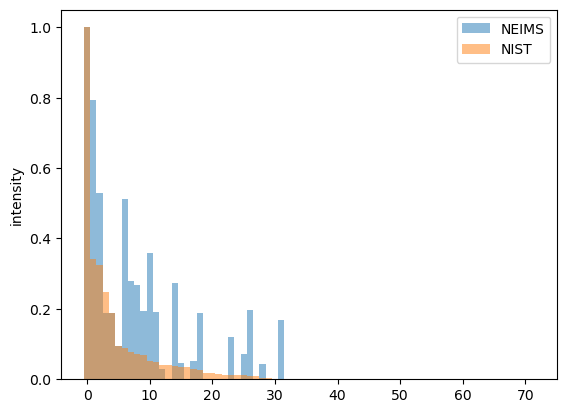

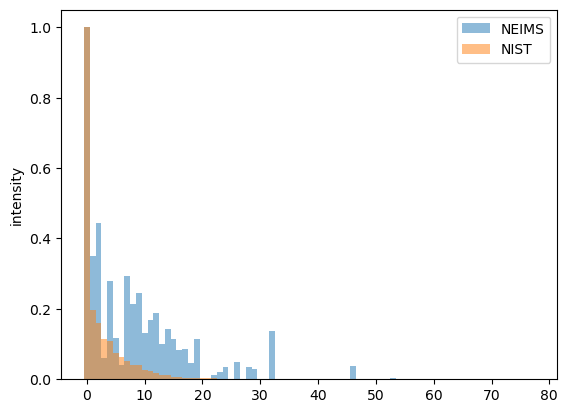

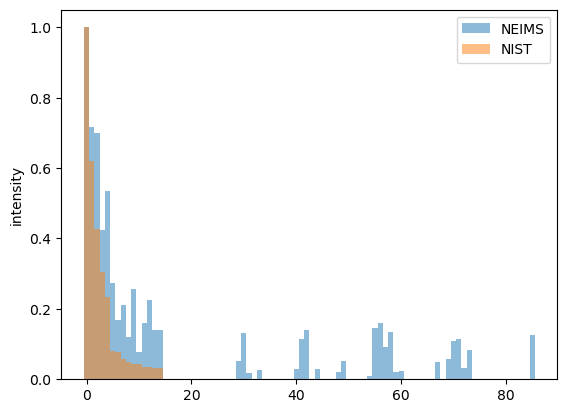

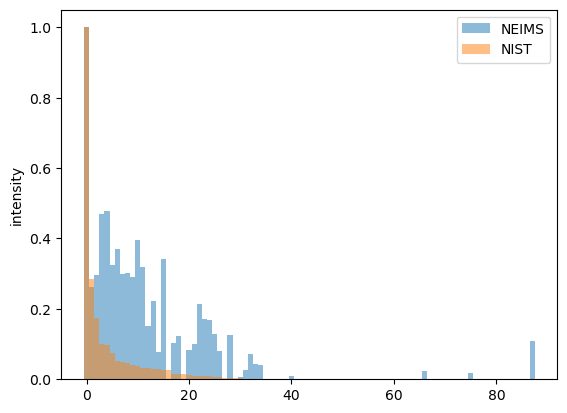

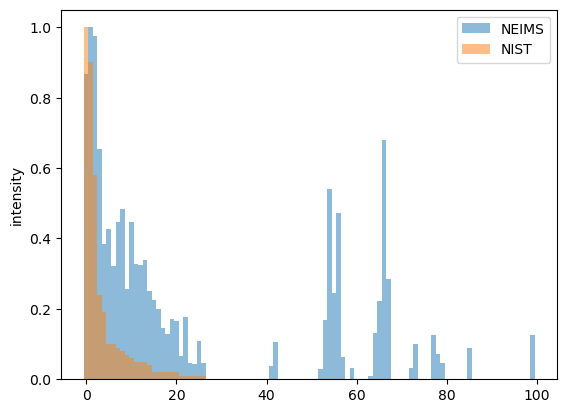

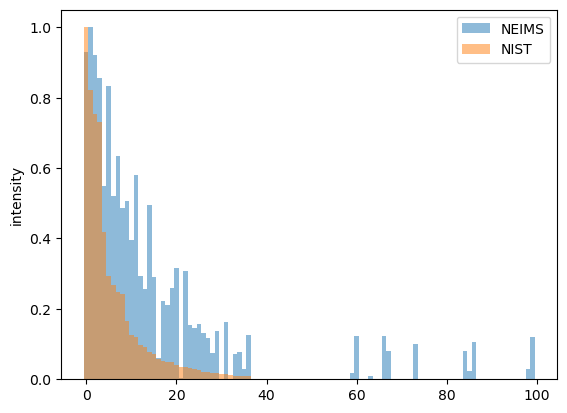

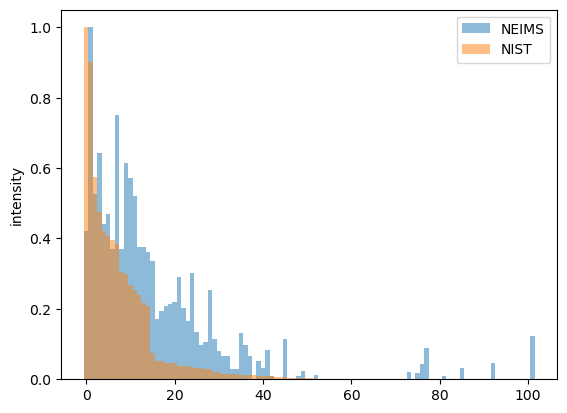

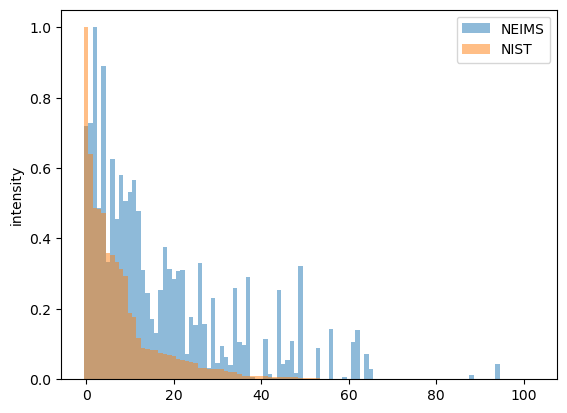

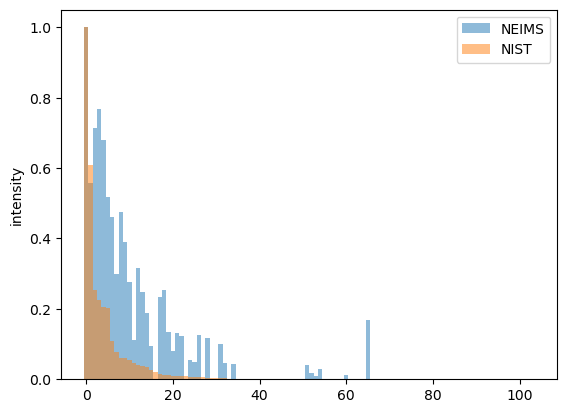

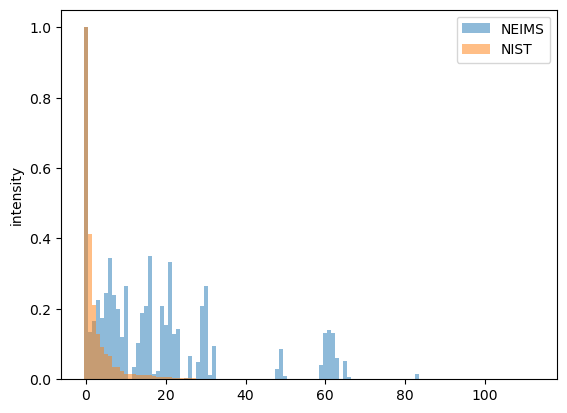

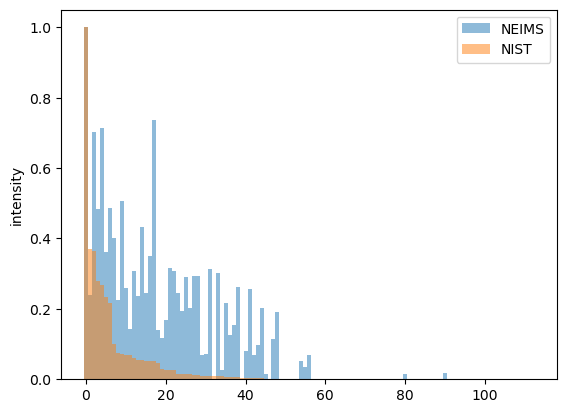

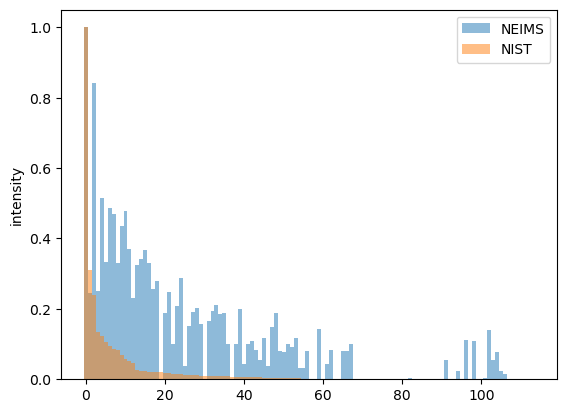

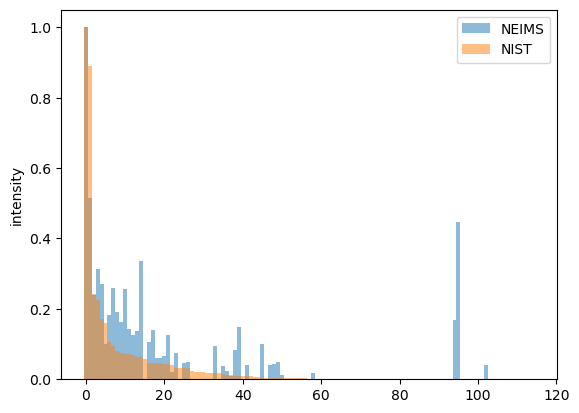

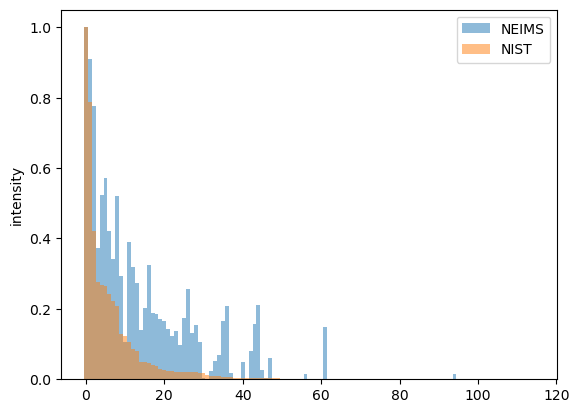

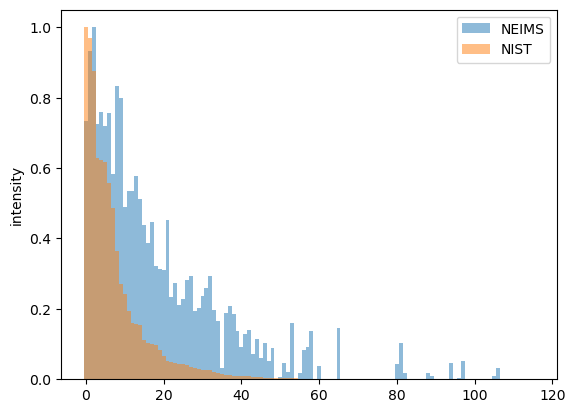

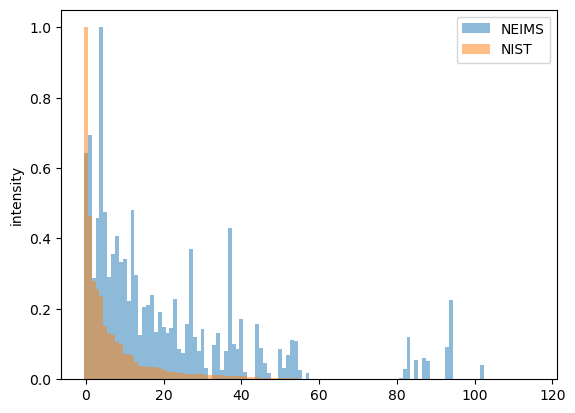

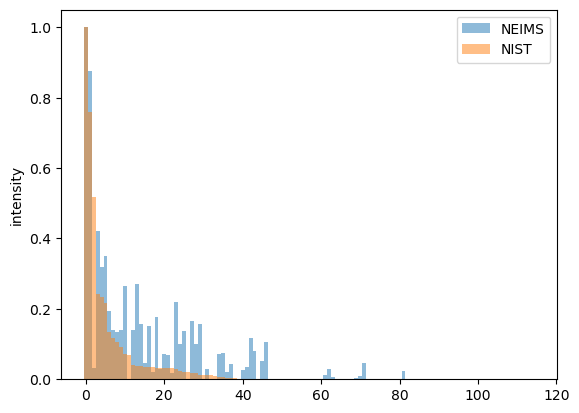

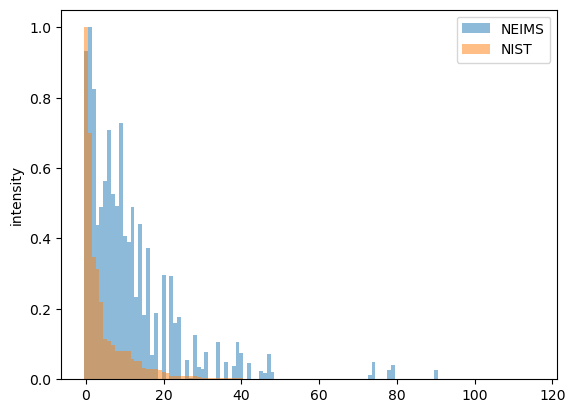

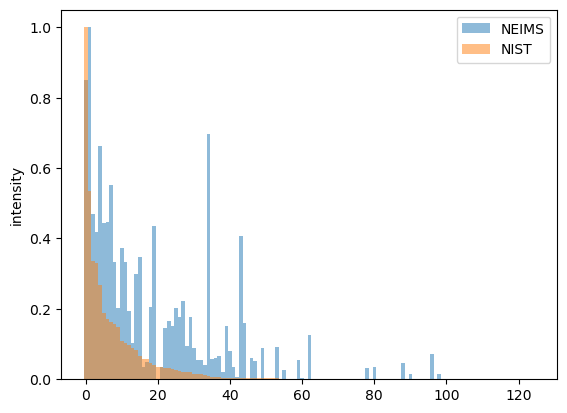

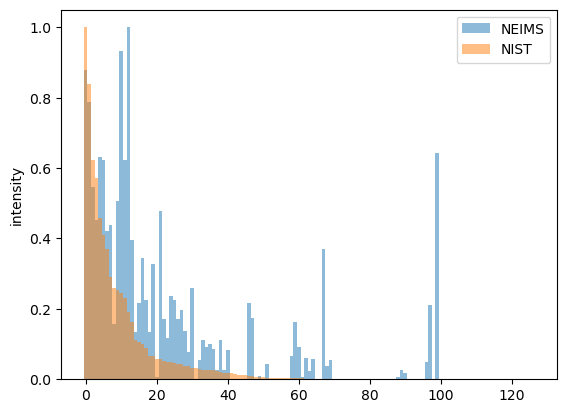

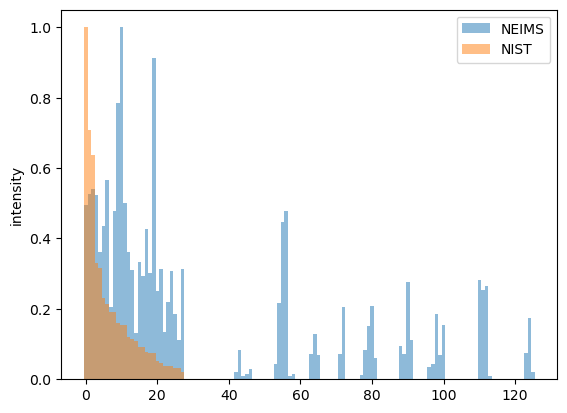

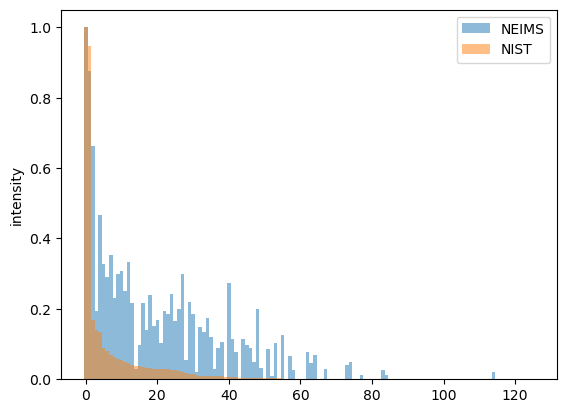

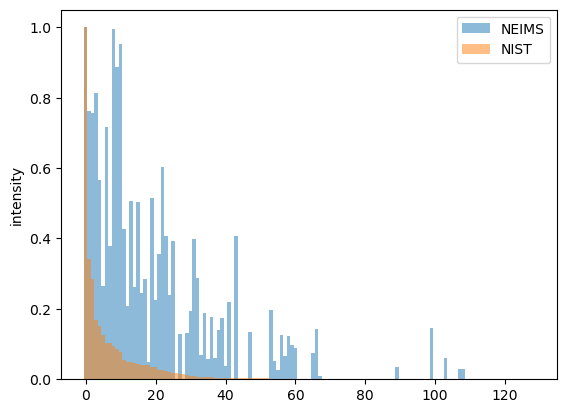

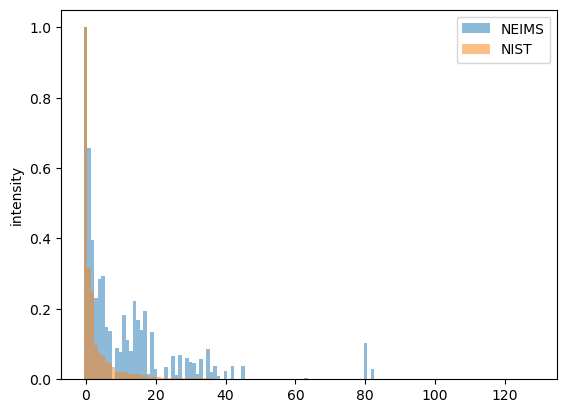

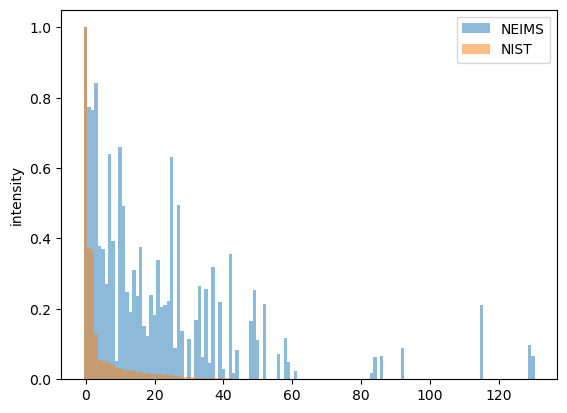

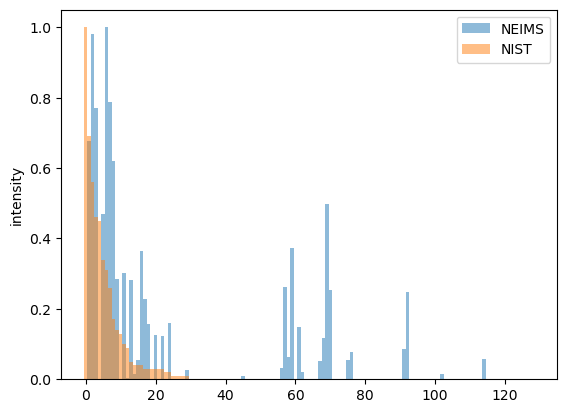

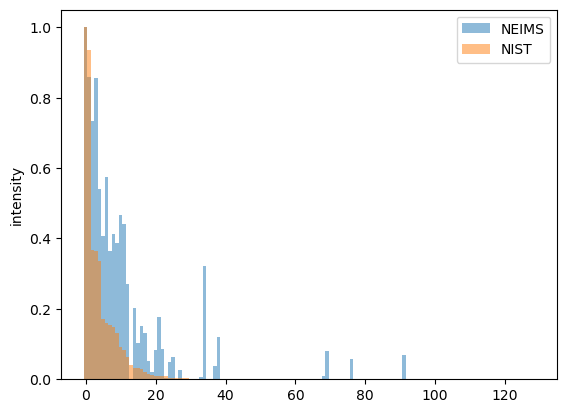

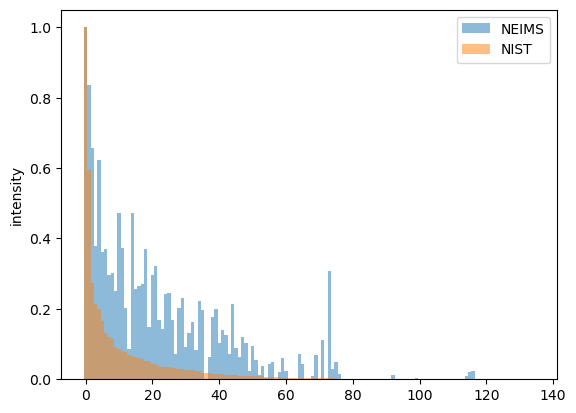

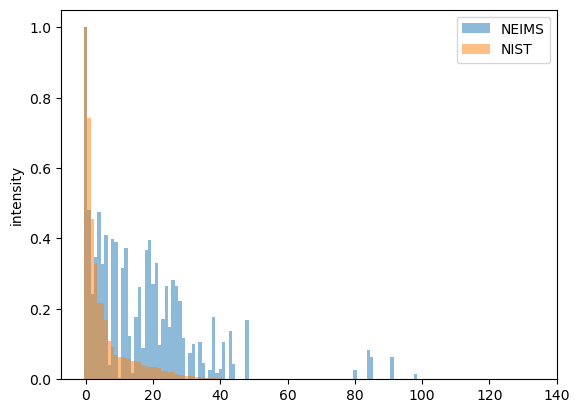

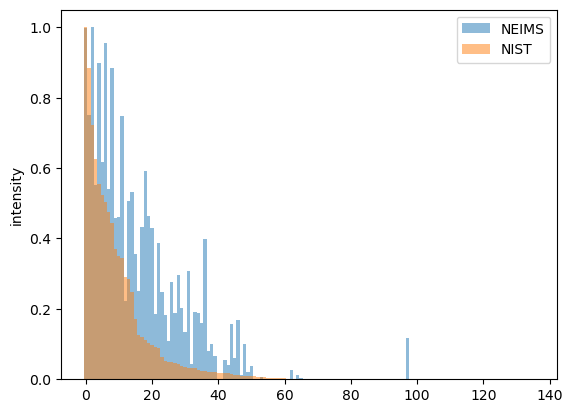

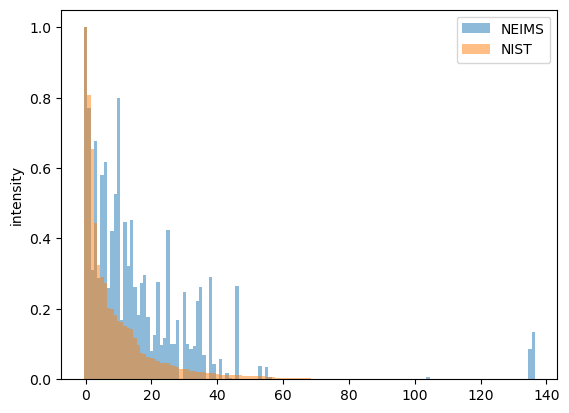

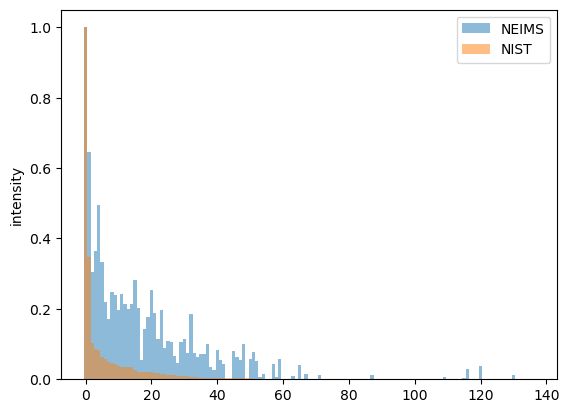

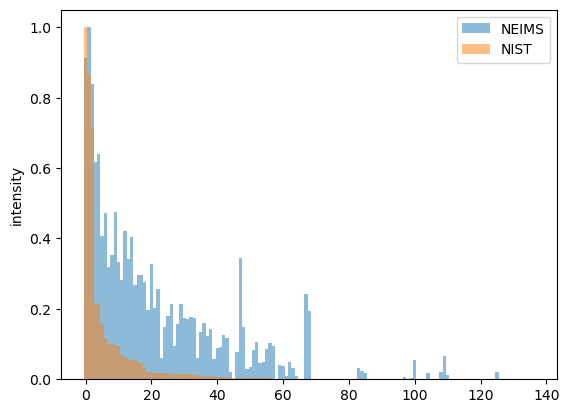

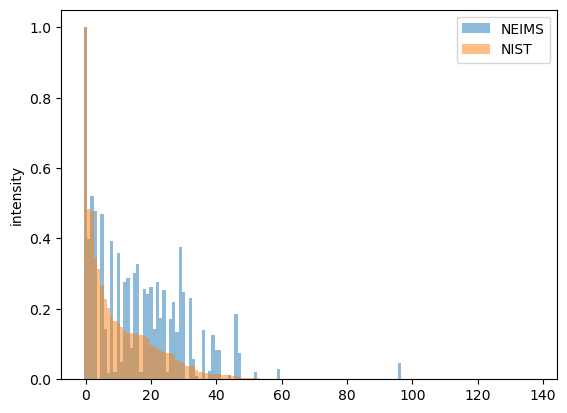

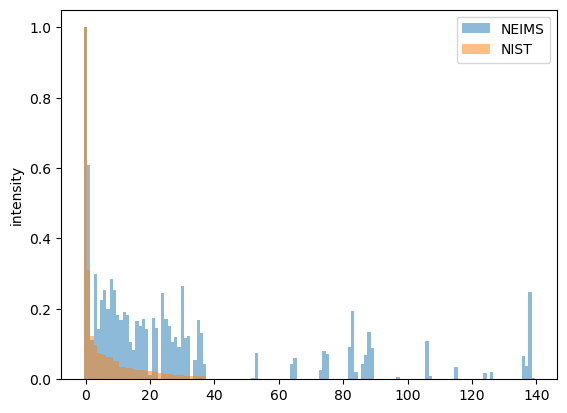

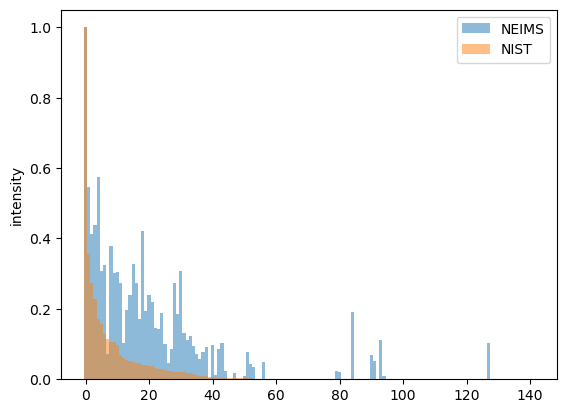

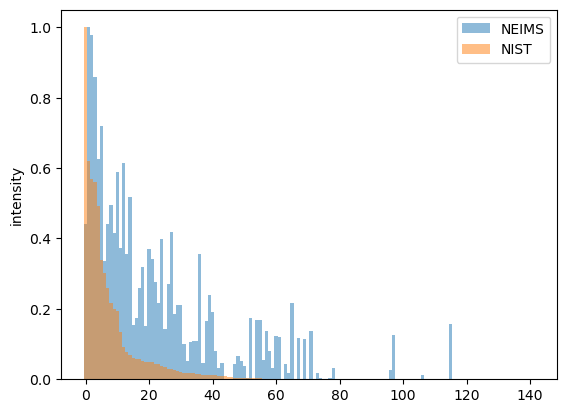

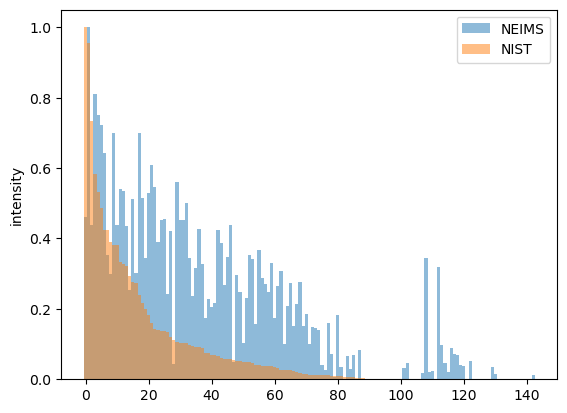

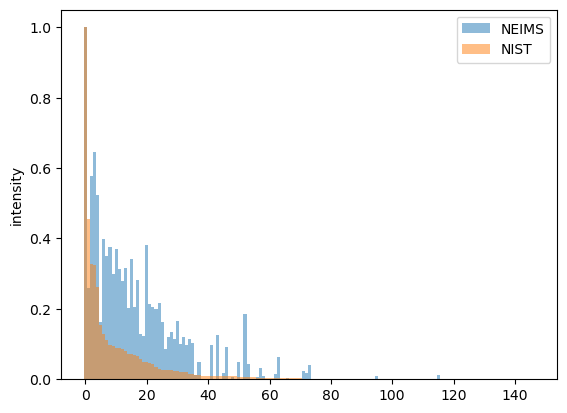

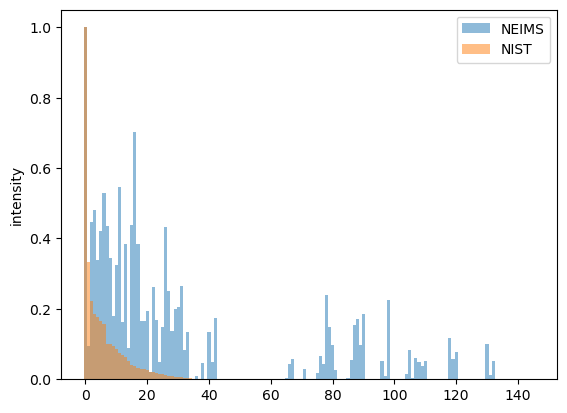

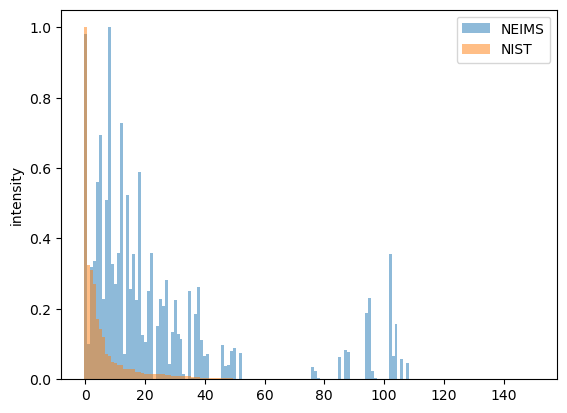

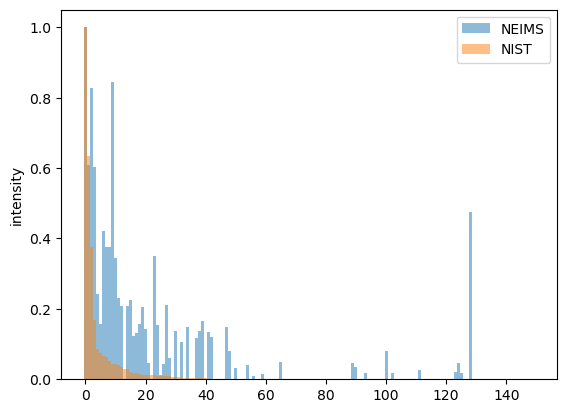

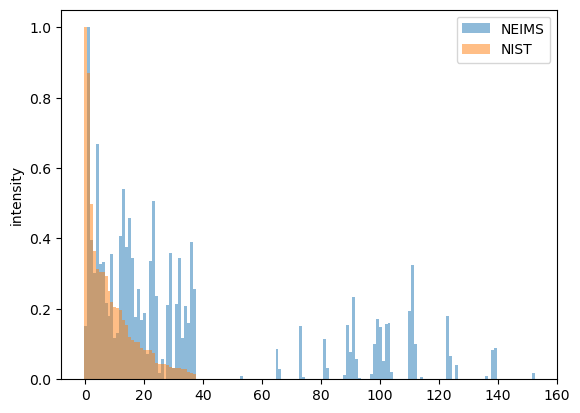

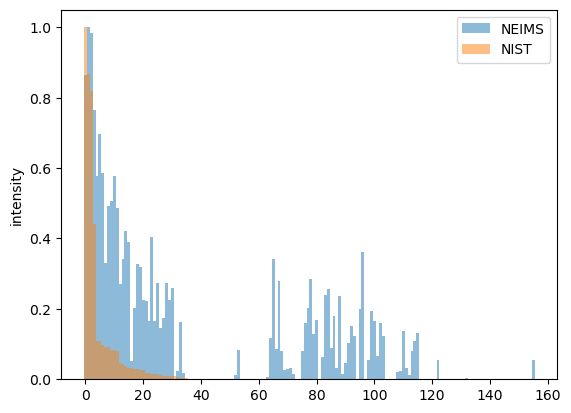

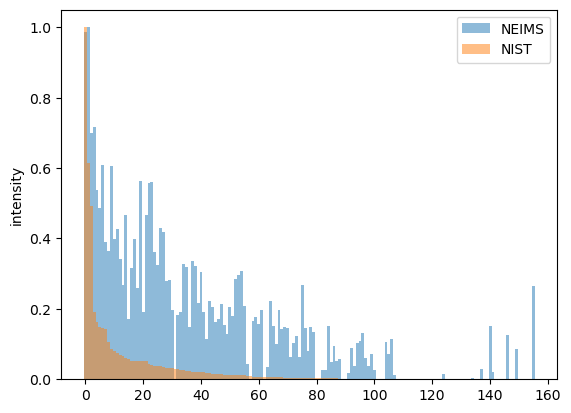

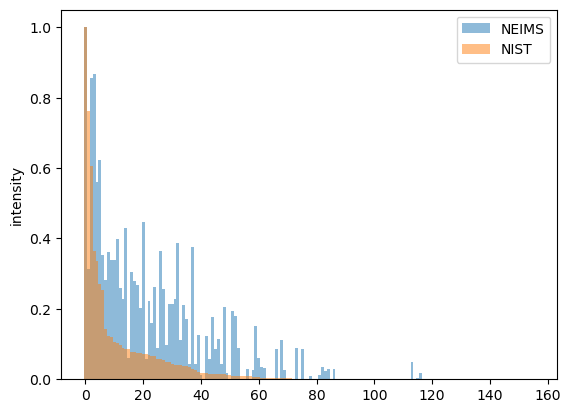

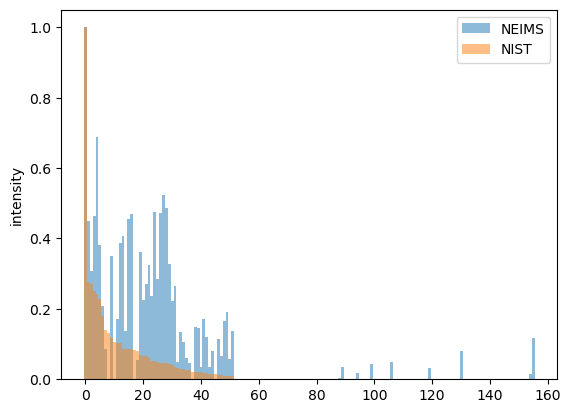

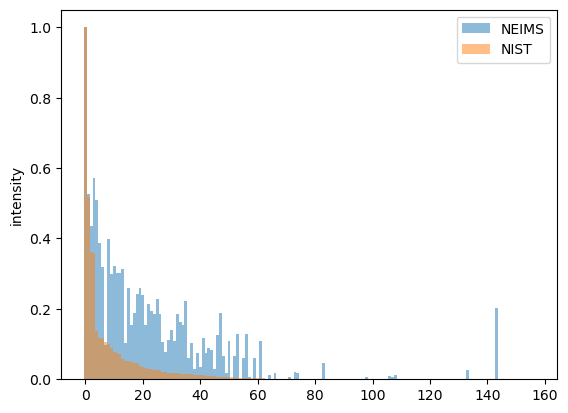

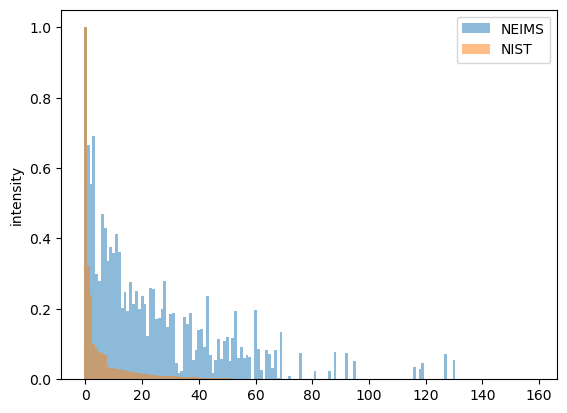

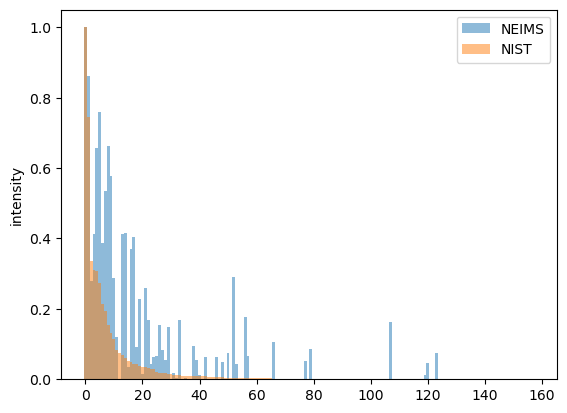

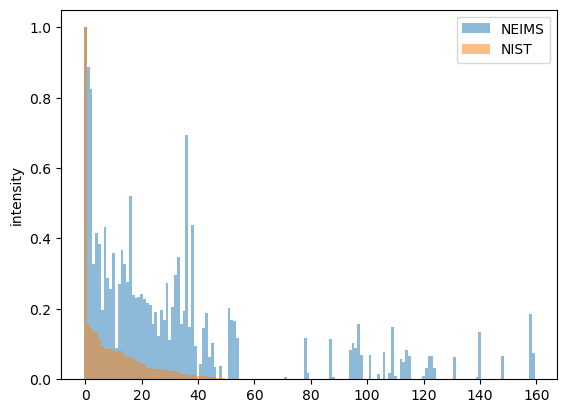

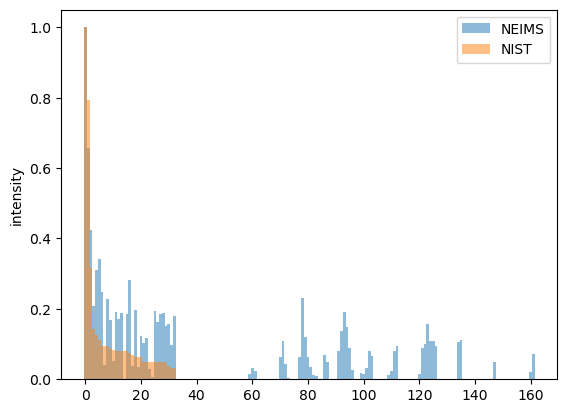

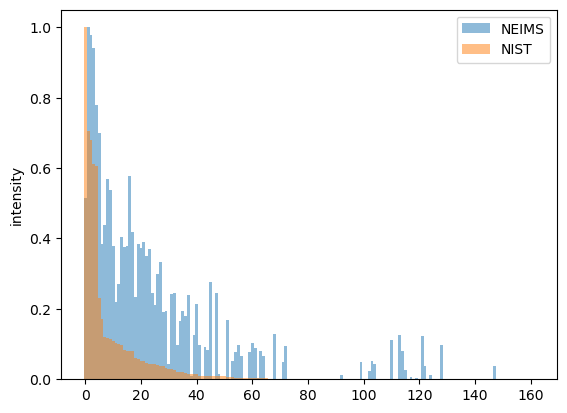

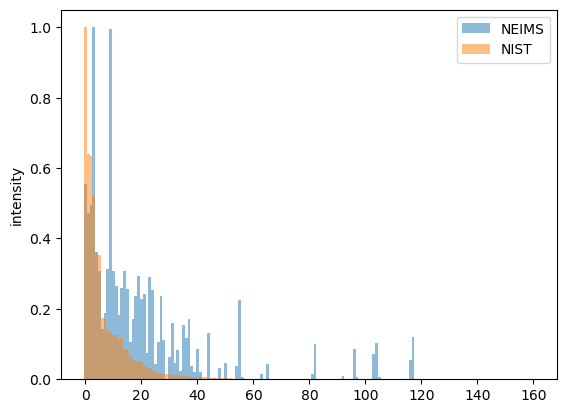

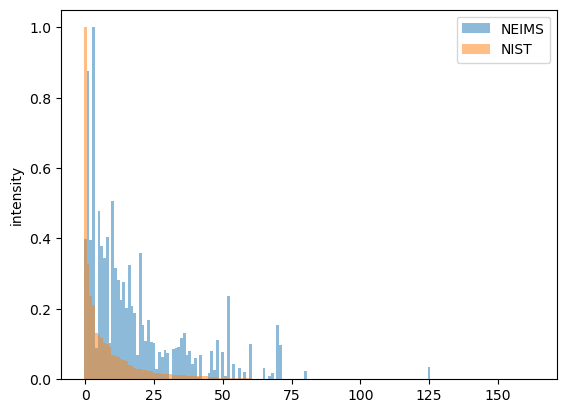

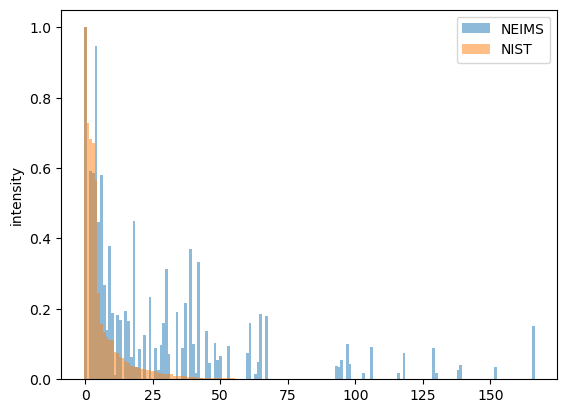

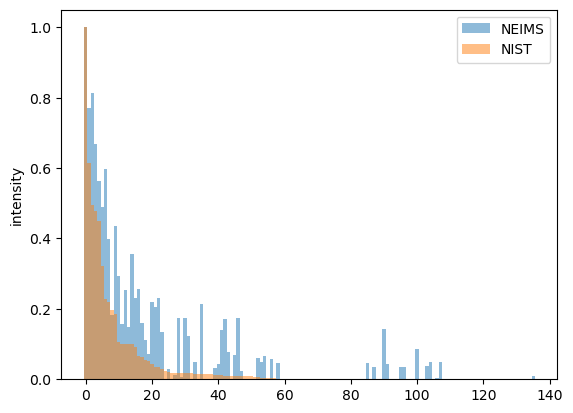

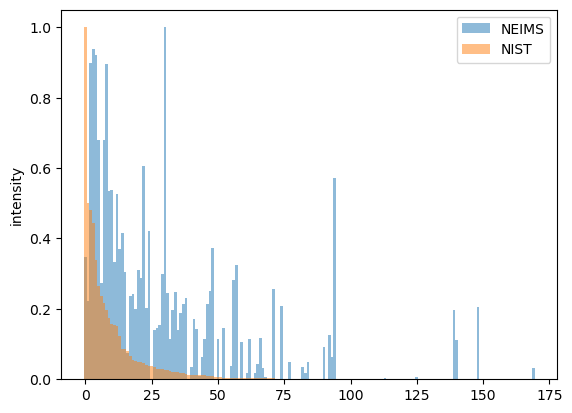

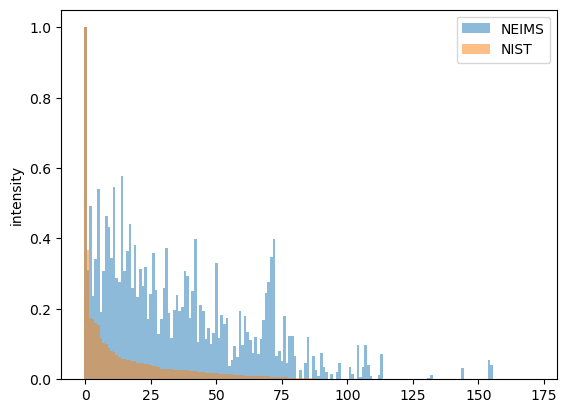

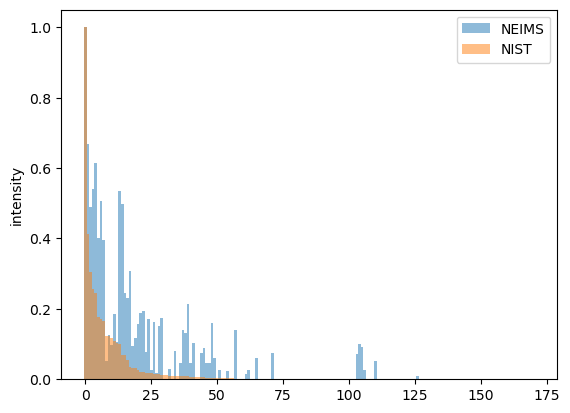

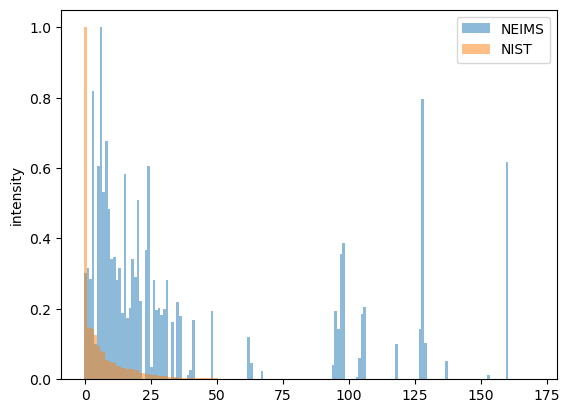

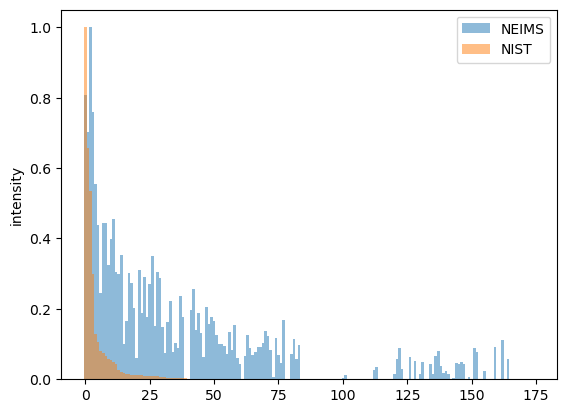

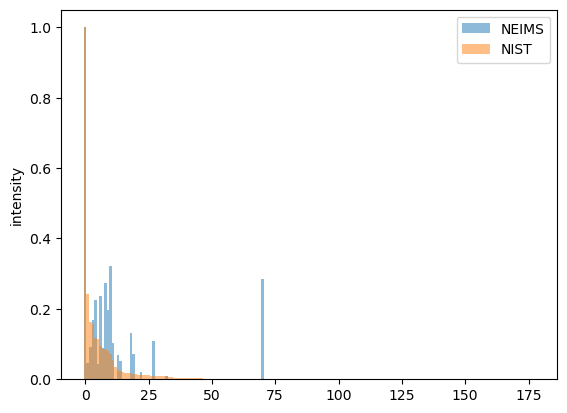

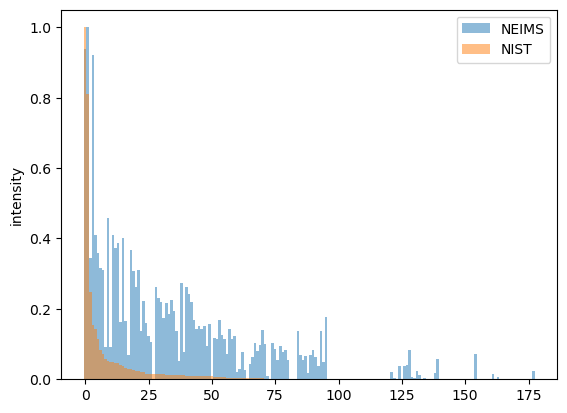

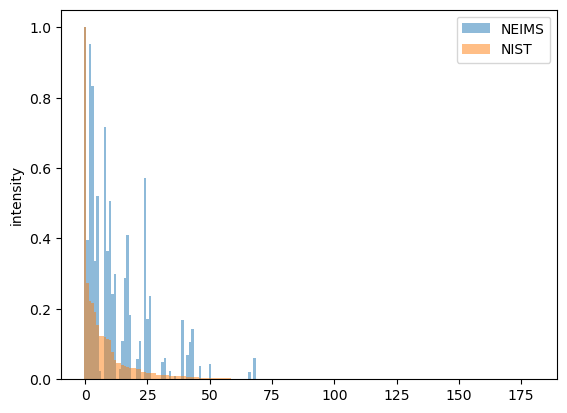

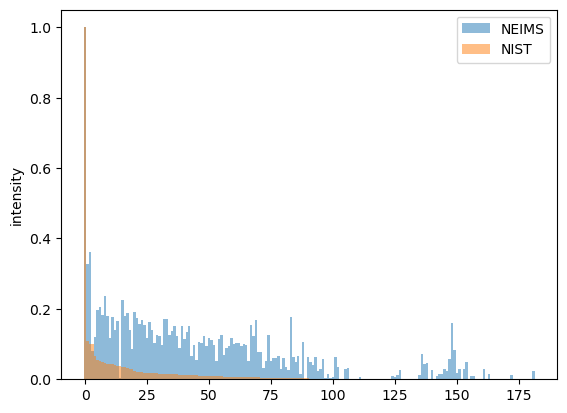

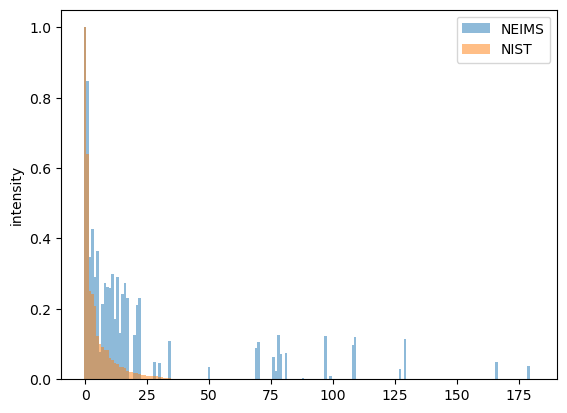

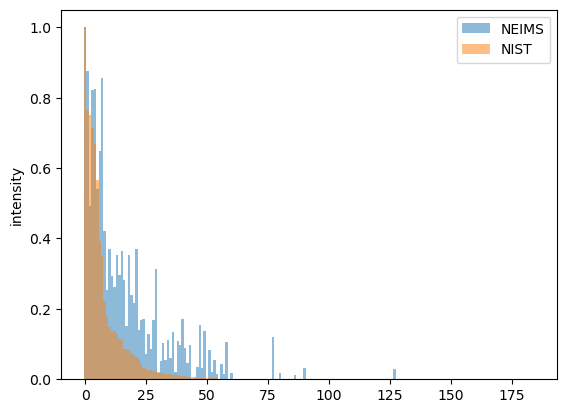

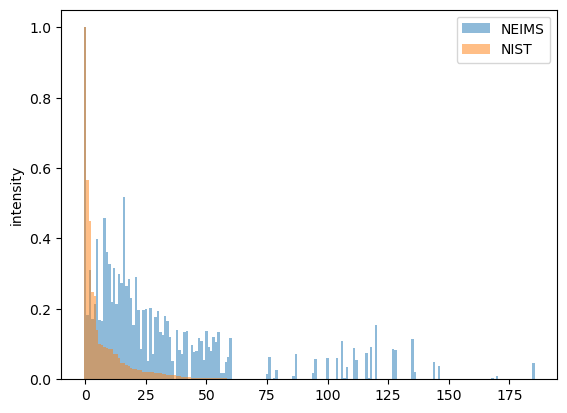

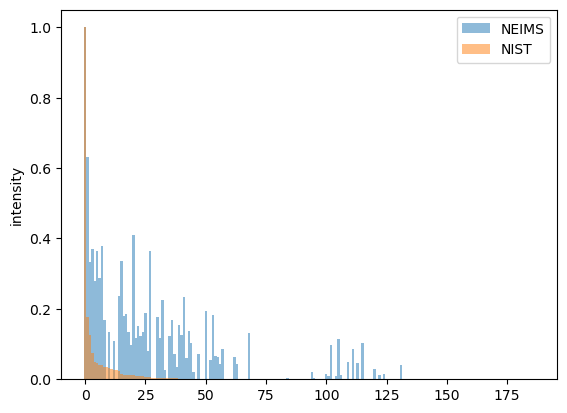

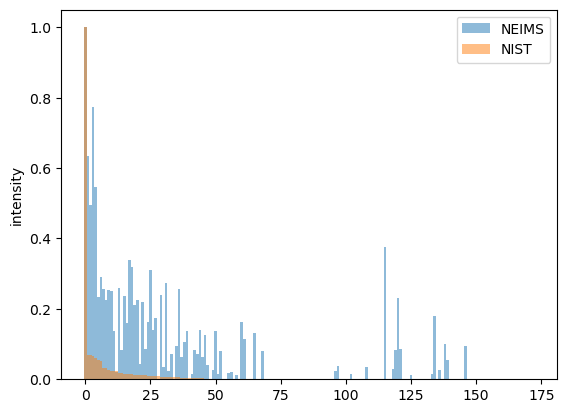

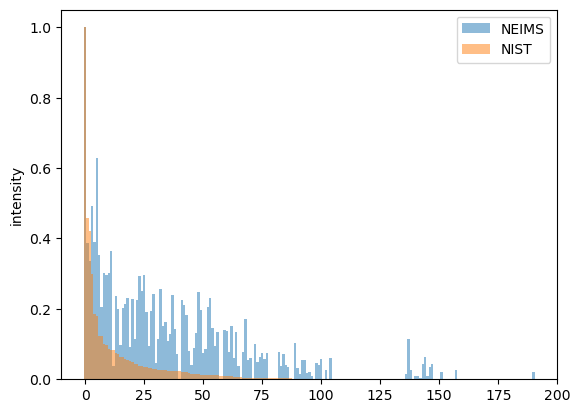

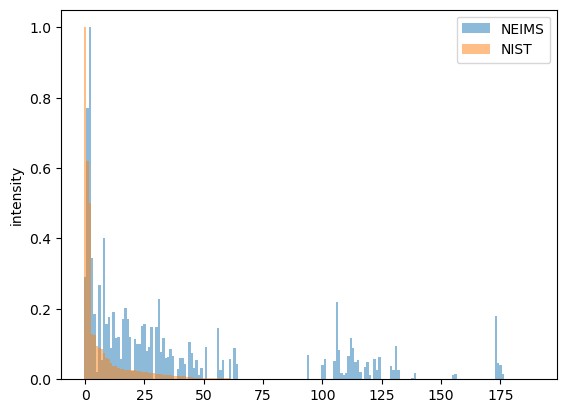

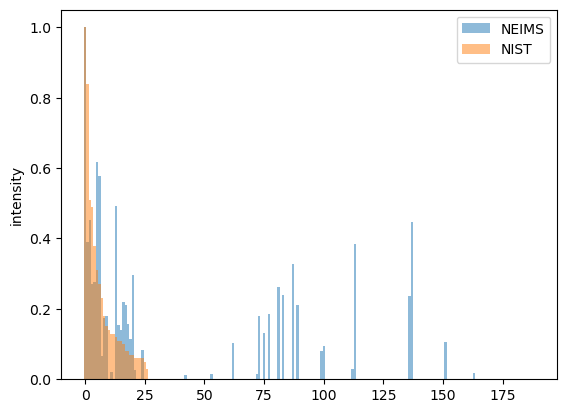

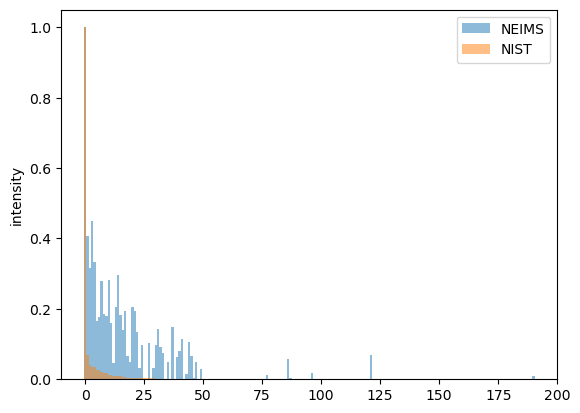

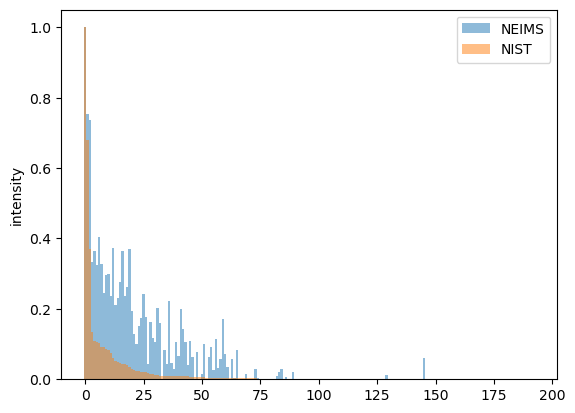

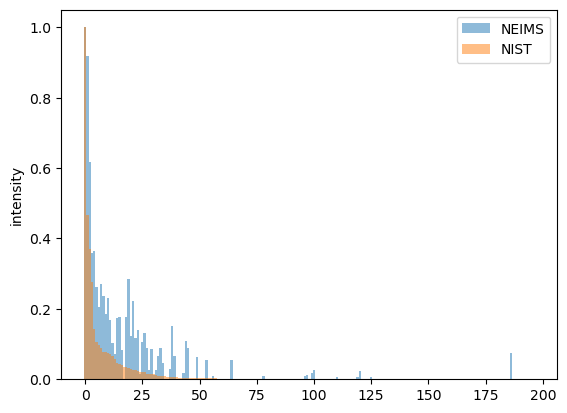

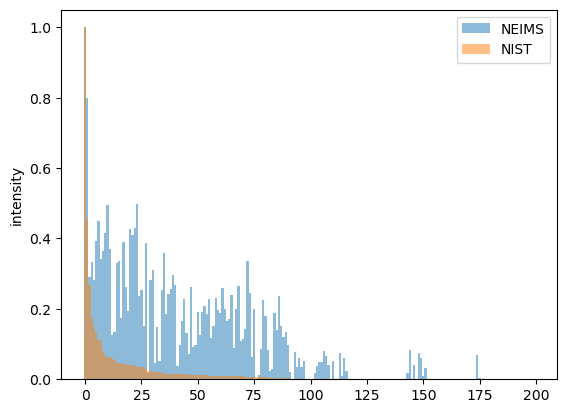

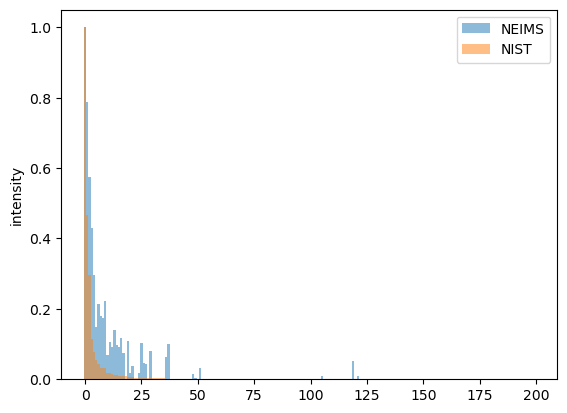

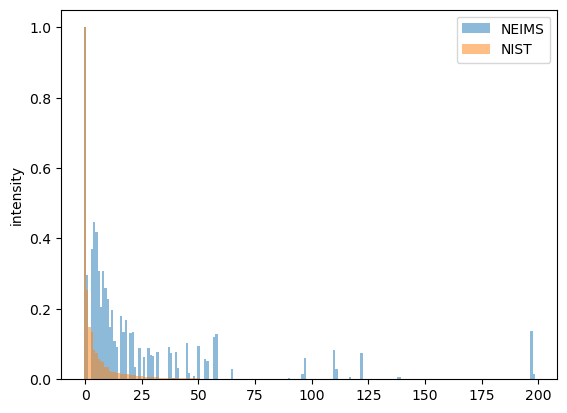

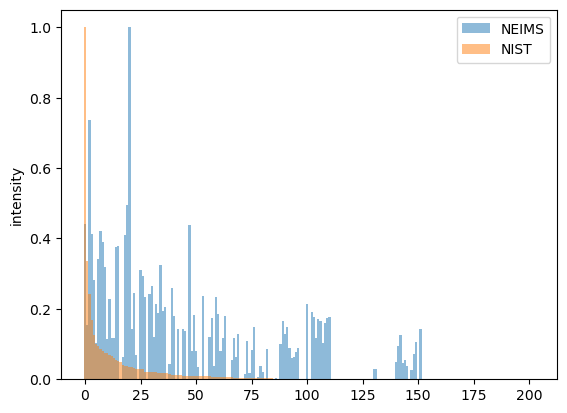

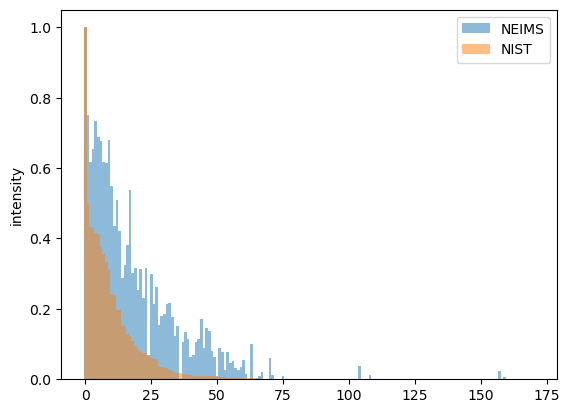

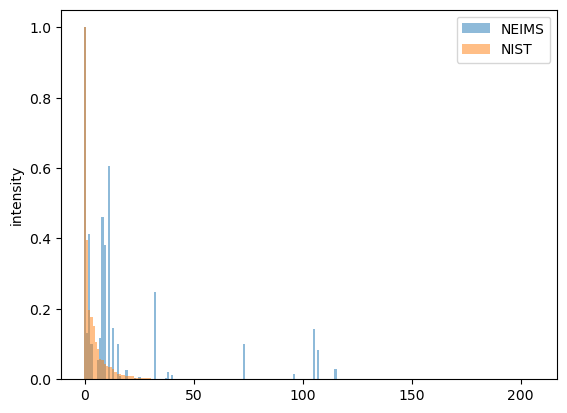

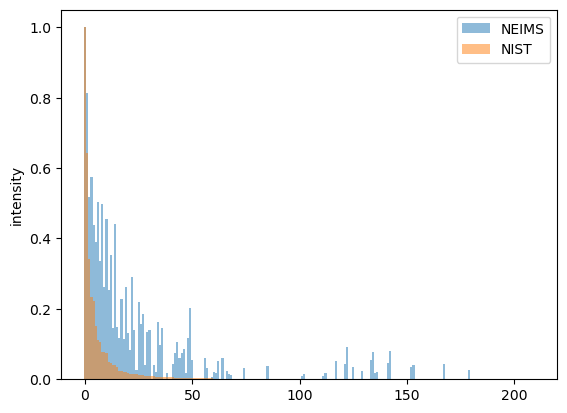

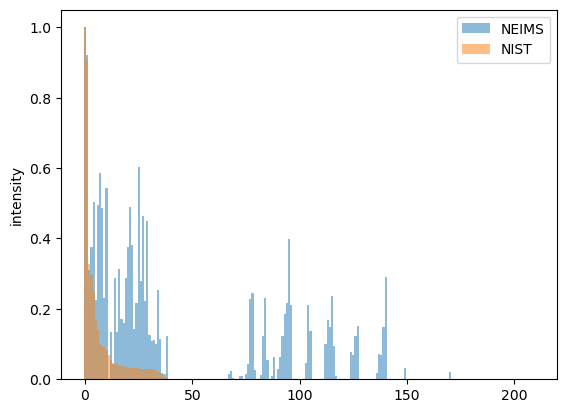

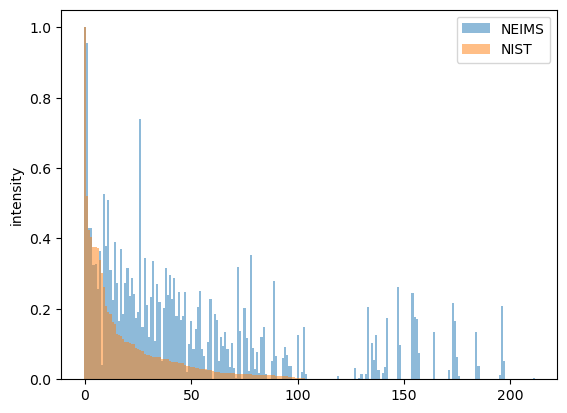

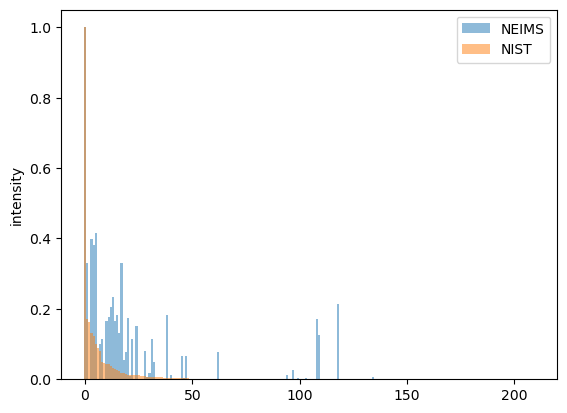

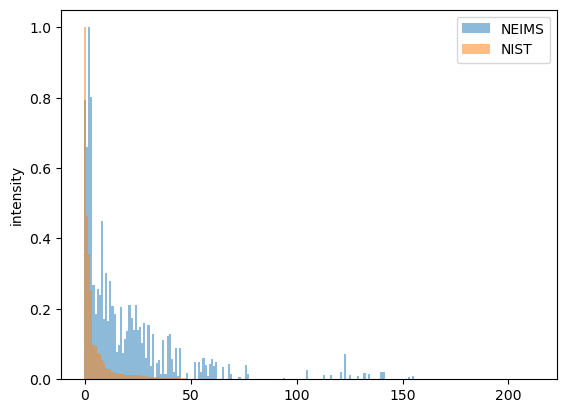

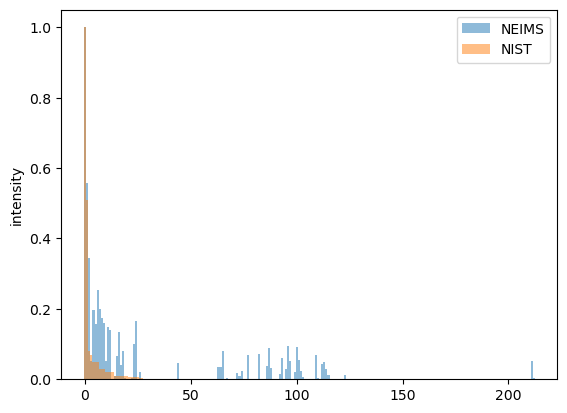

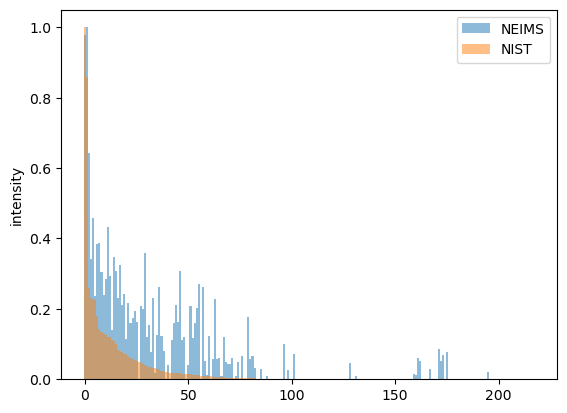

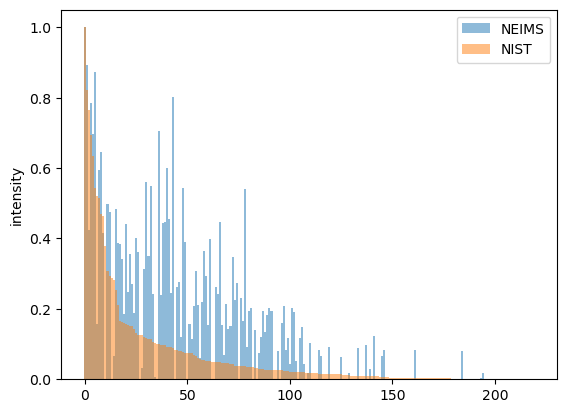

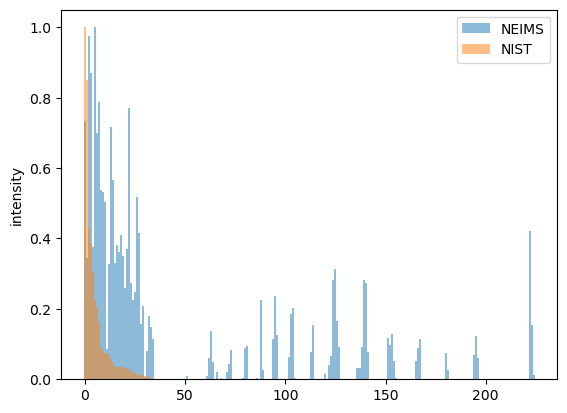

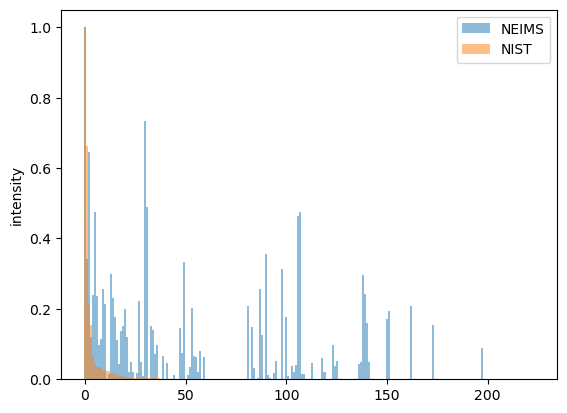

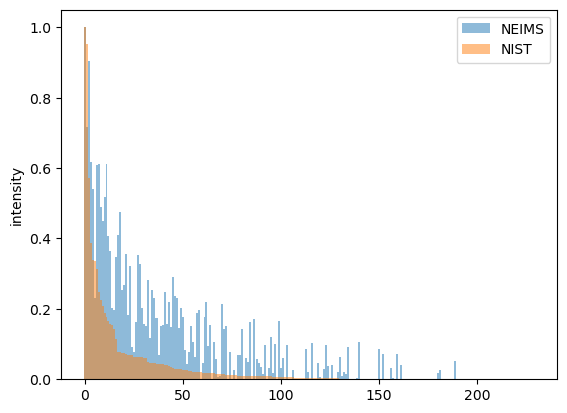

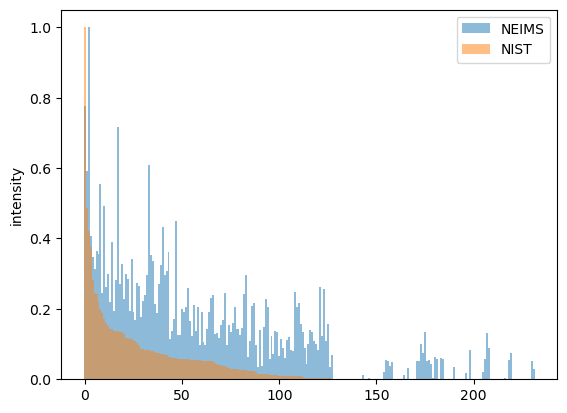

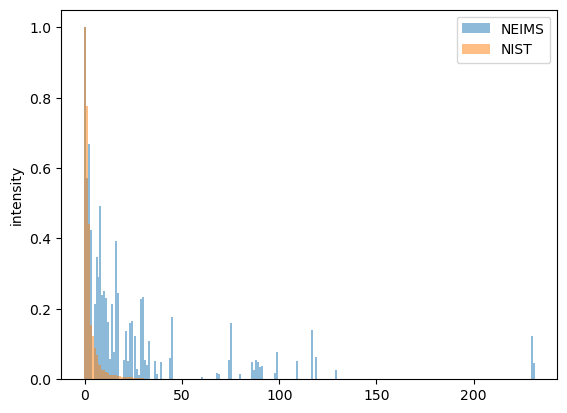

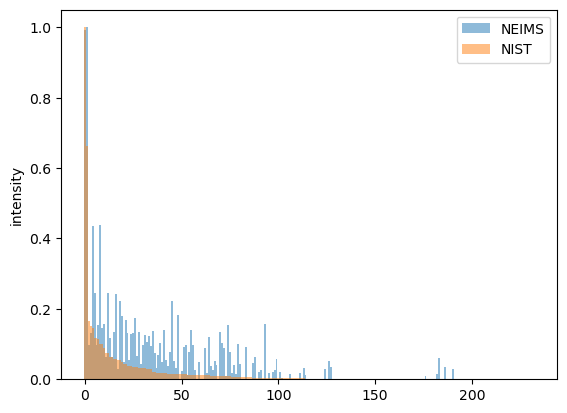

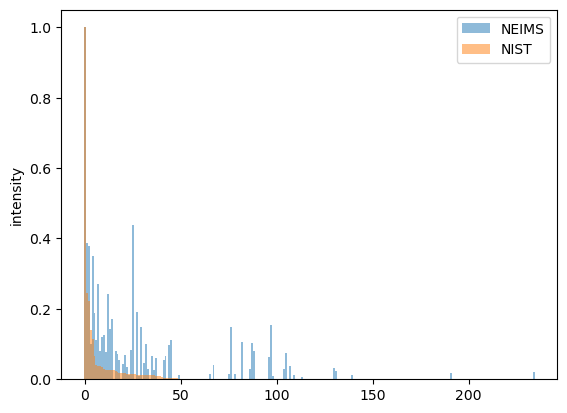

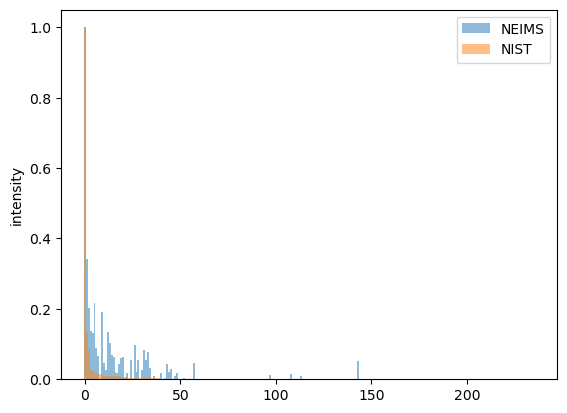

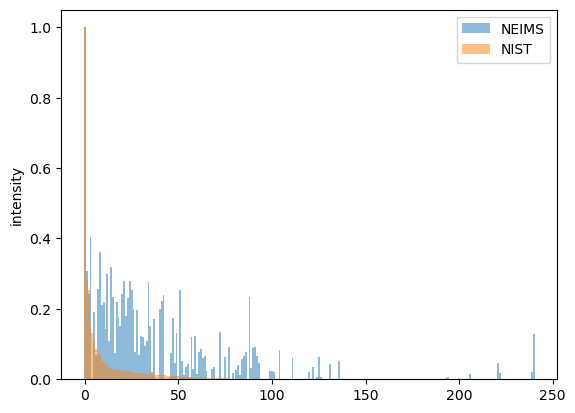

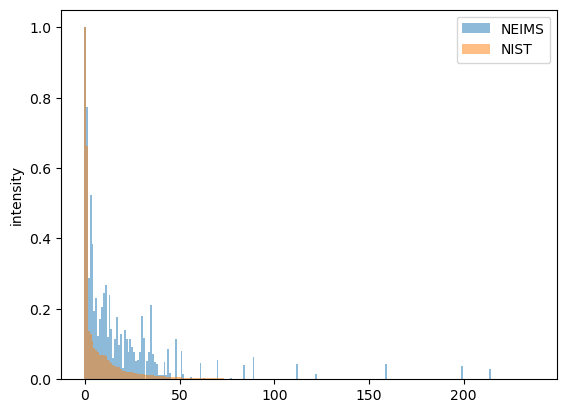

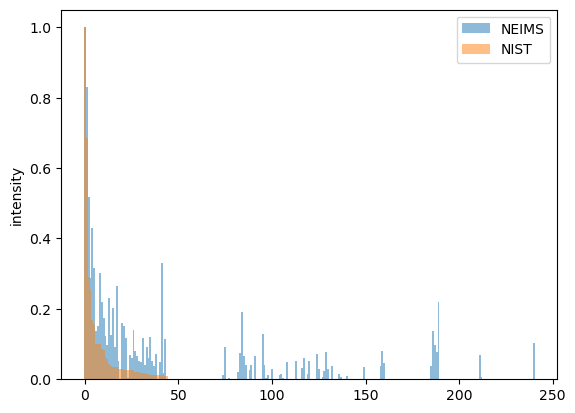

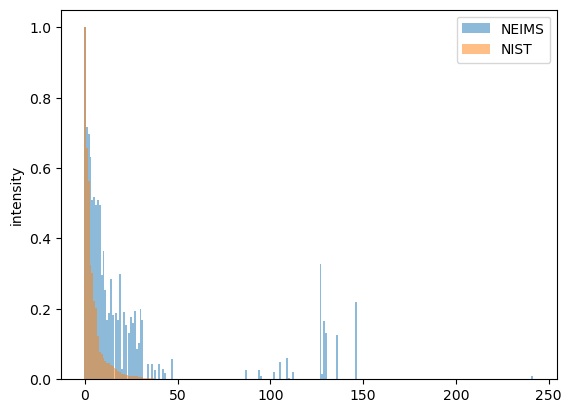

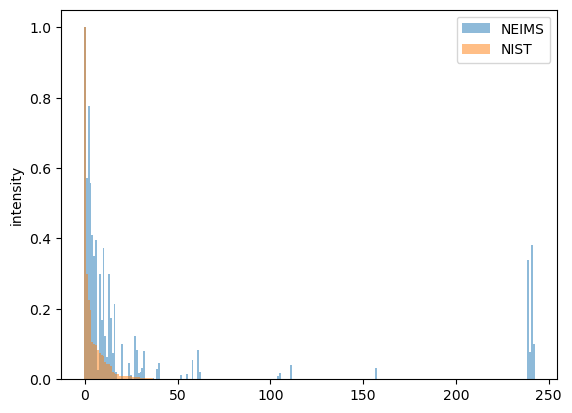

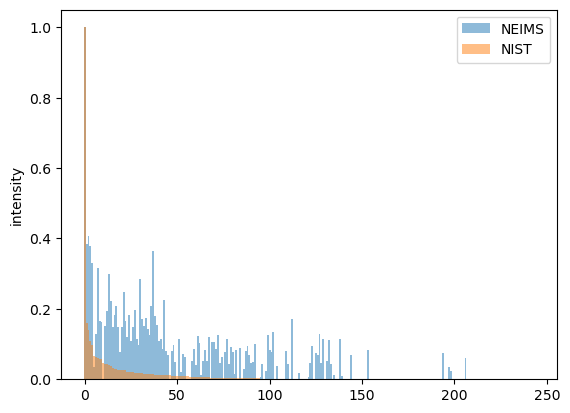

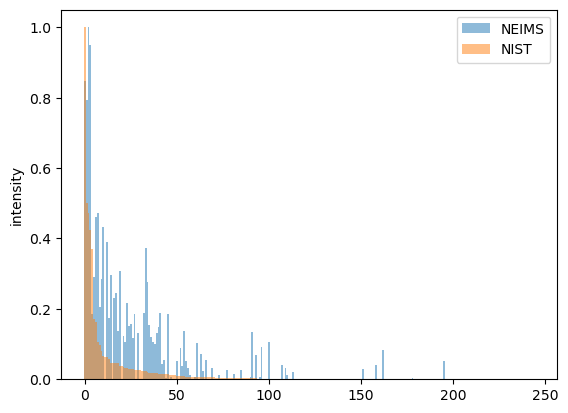

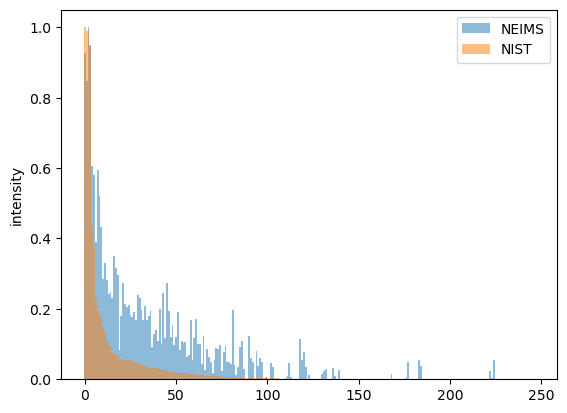

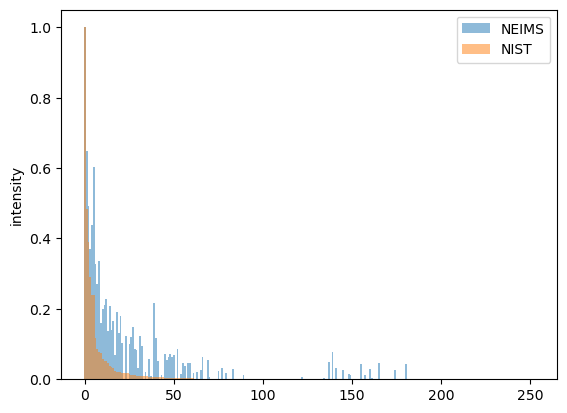

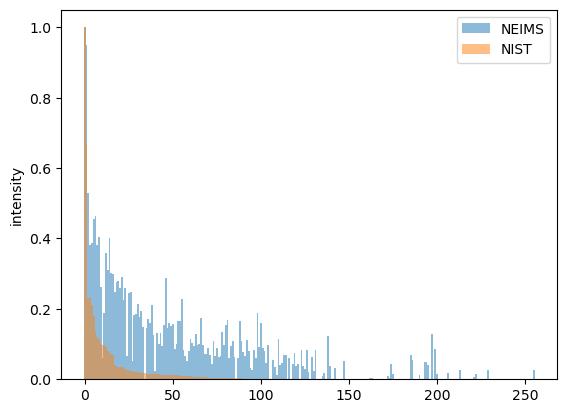

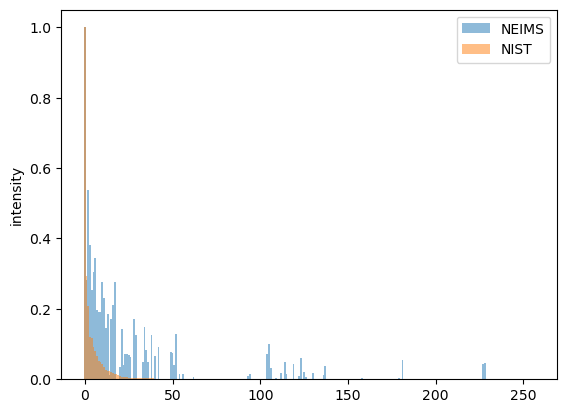

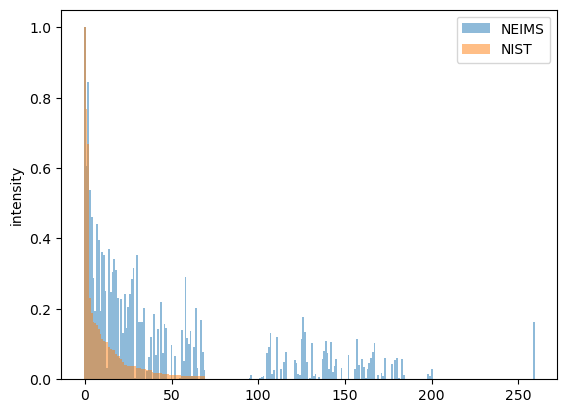

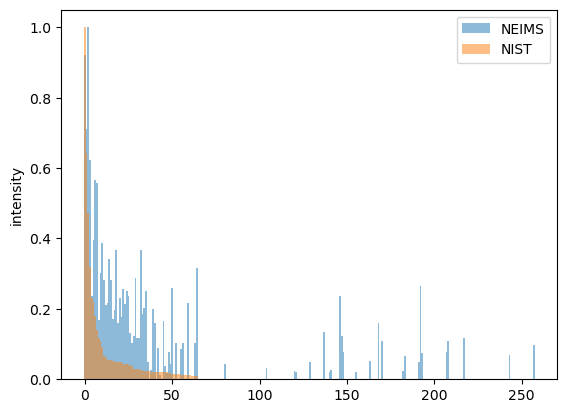

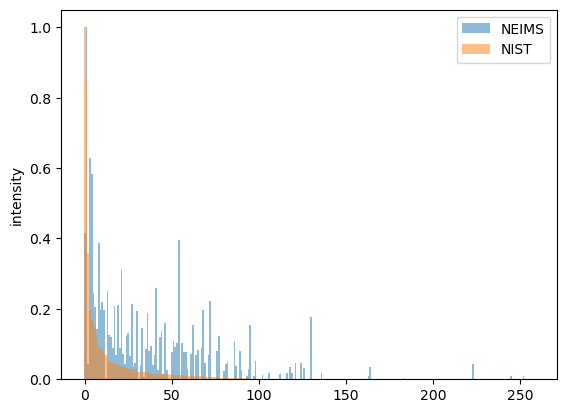

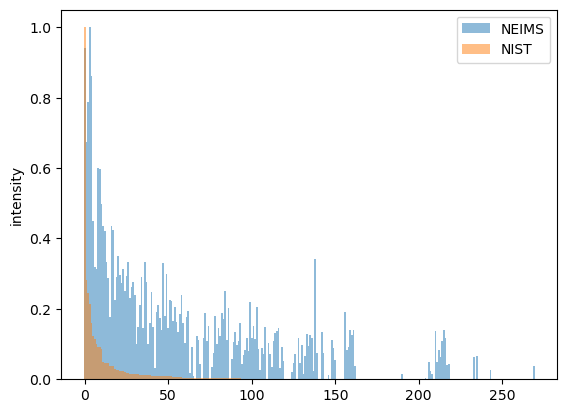

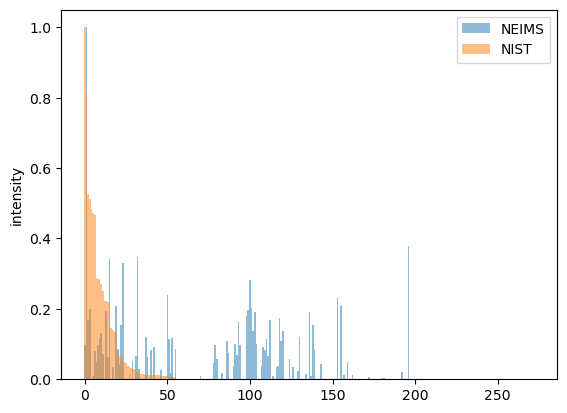

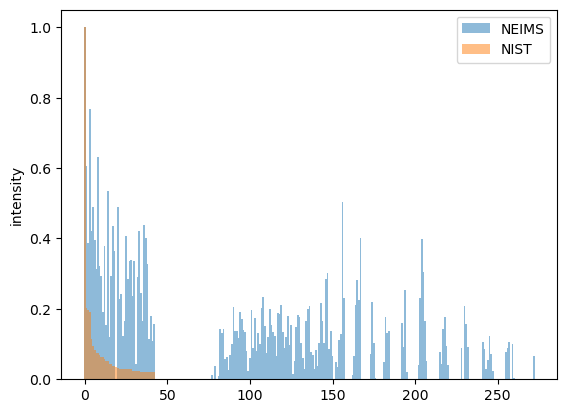

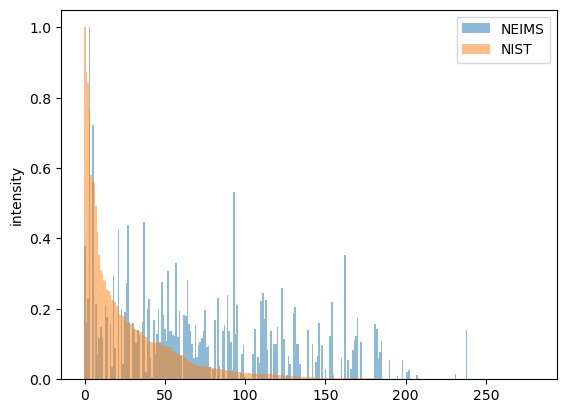

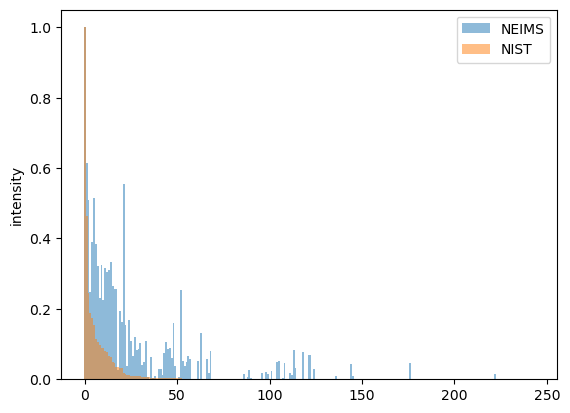

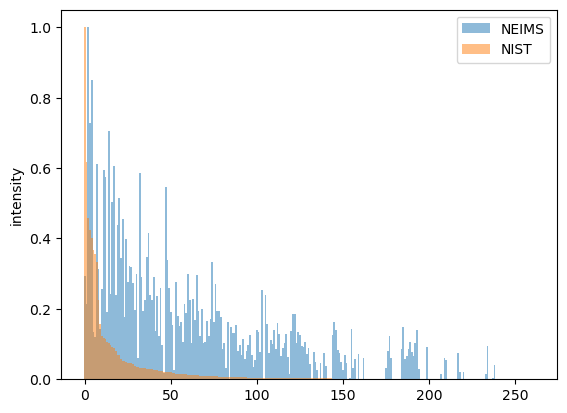

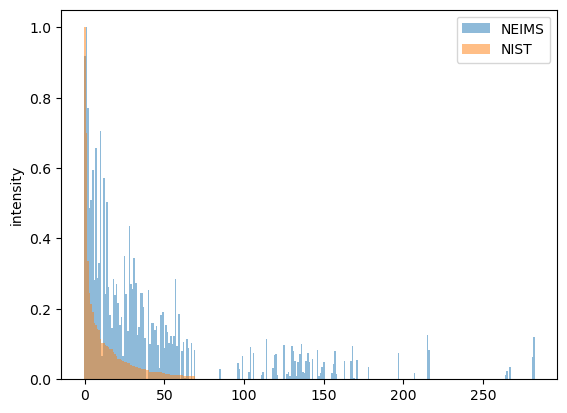

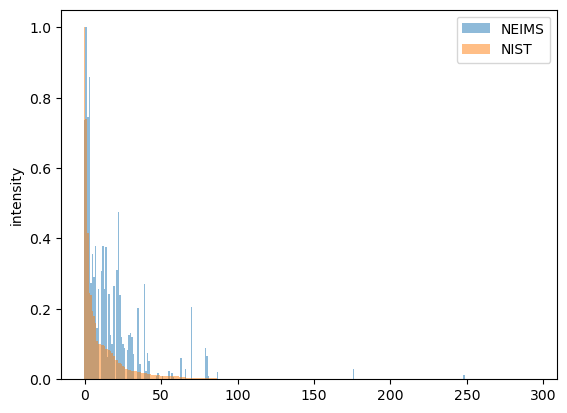

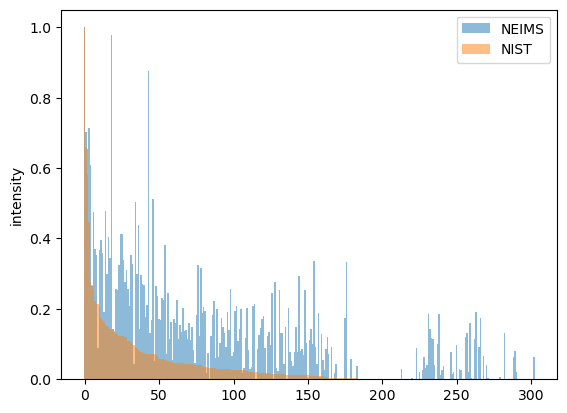

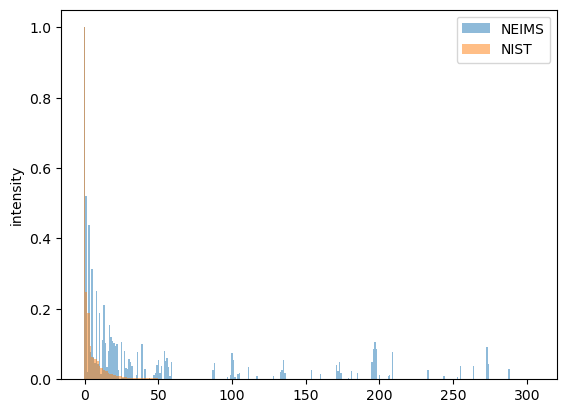

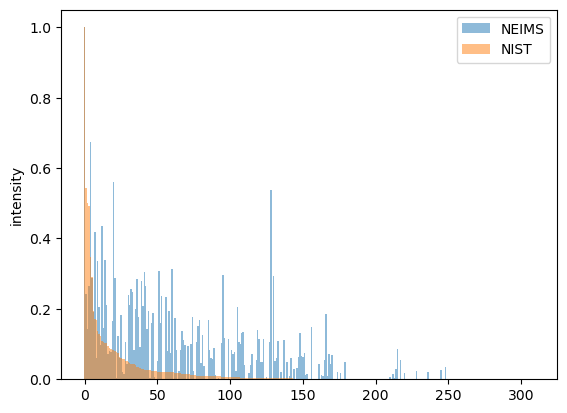

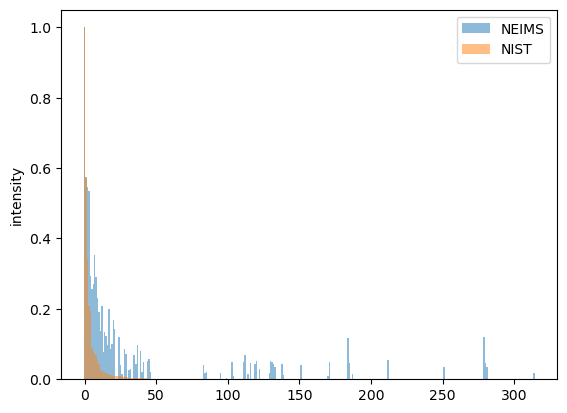

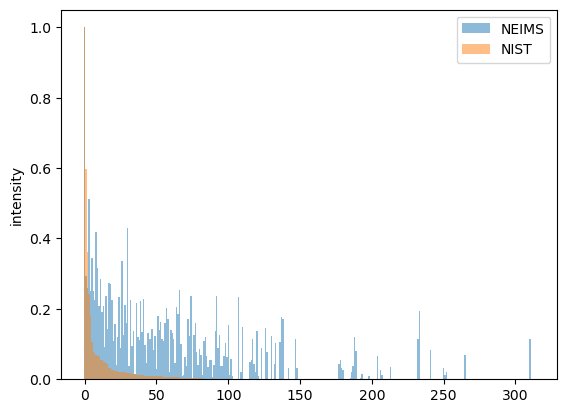

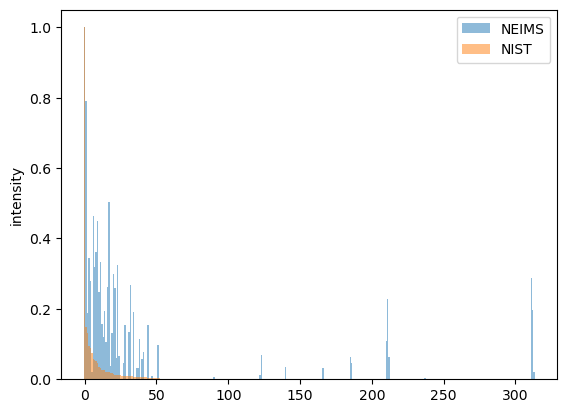

KeyboardInterrupt: 

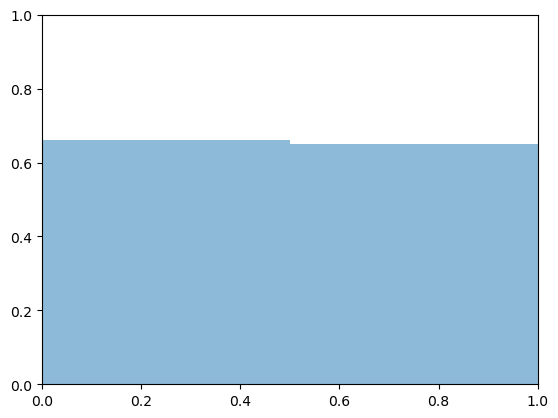

In [188]:
# take neims and nist corresponding spectra and enlong one of them to fit the other (with zeros)
# sort both according to the NIST. You can plot it I guess
def get_sorted_mzs(nist_arr, neims_arr):
    # pad the arrays
    neims_l = neims_arr.shape[0]
    nist_l = nist_arr.shape[0]
    if nist_l < neims_l:
        nist_arr = np.pad(nist_arr, (0, neims_l - nist_l))
    else: 
        neims_arr = np.pad(neims_arr, (0, nist_l - neims_l))
    zipped = list(zip(nist_arr, neims_arr))
    zipped.sort(key=lambda x : x[0], reverse=True)
    
    nist_arr = [x for x,y in zipped]
    neims_arr = [y for x,y in zipped]
    
    return nist_arr, neims_arr

for key in nist_test_spec.keys():
    nist_arr, neims_arr = get_sorted_mzs(nist_test_spec[key]["spectrum"], neims_test_spec[key]["spectrum"])
    visualize_two_spectra_1array(neims_arr, nist_arr)

## Measure the peak overlap in the n biggest peaks

[(16, 20), (18, 20), (14, 15), (15, 20), (15, 20), (18, 20), (16, 20), (16, 20), (17, 20), (14, 20), (12, 20), (18, 20), (16, 20), (17, 20), (19, 20), (16, 20), (15, 20), (18, 20), (16, 20), (15, 20), (16, 20), (15, 20), (14, 20), (18, 20), (13, 20), (13, 20), (17, 20), (17, 20), (14, 20), (17, 20), (16, 20), (16, 20), (18, 20), (13, 20), (13, 20), (16, 20), (15, 20), (12, 20), (16, 20), (14, 20), (15, 20), (16, 20), (13, 20), (17, 20), (15, 20), (16, 20), (12, 20), (16, 20), (16, 20), (16, 20), (15, 20), (14, 20), (17, 20), (15, 20), (17, 20), (12, 20), (15, 20), (13, 20), (12, 20), (14, 20), (13, 20), (15, 20), (16, 20), (15, 20), (14, 20), (13, 20), (17, 20), (18, 20), (16, 20), (12, 20), (14, 20), (12, 20), (13, 20), (11, 20), (16, 20), (19, 20), (16, 20), (13, 20), (17, 20), (15, 20), (12, 20), (18, 20), (12, 20), (16, 20), (12, 20), (13, 20), (13, 20), (16, 20), (13, 20), (15, 20), (10, 20), (15, 20), (9, 20), (16, 20), (12, 20), (15, 20), (12, 20), (12, 20), (14, 20), (10, 20), 

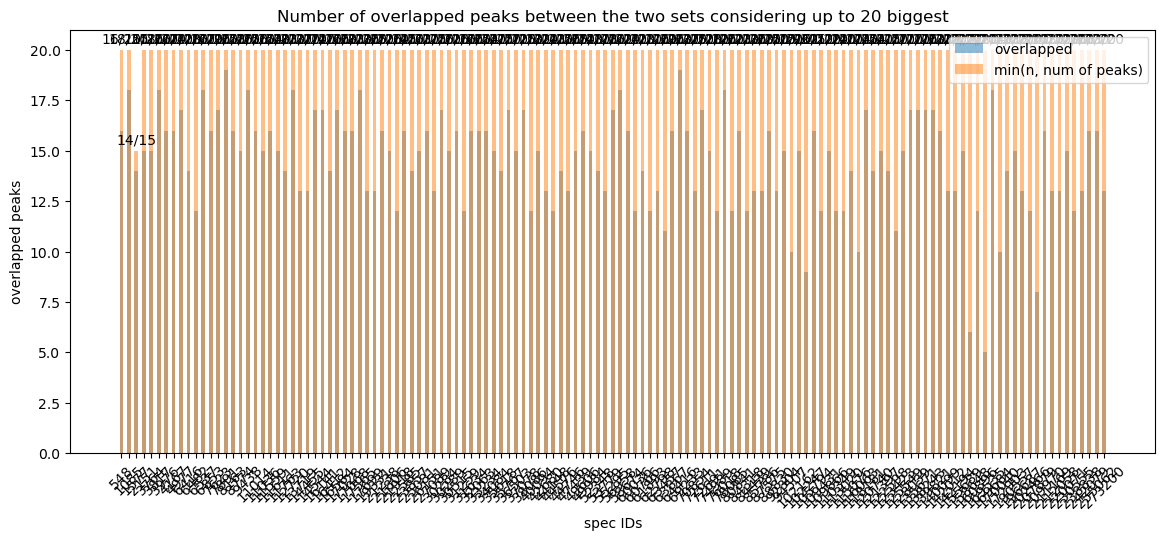

In [190]:
# extract n biggest mzs according to intensities and compute the overlap
def compute_overlap(neims_spec, nist_spec, n):
    zipped_nist = sorted(list(zip(nist_spec["mz"], nist_spec["intensity"])), key=lambda x : x[1], reverse=True)
    zipped_neims = sorted(list(zip(neims_spec["mz"], neims_spec["intensity"])), key=lambda x : x[1], reverse=True)
    
    n_mzs_nist = np.array([x for x,y in zipped_nist])[:min(n, len(zipped_nist))]
    n_mzs_neims = np.array([x for x,y in zipped_neims])[:min(n, len(zipped_neims))]
    overlap_size = sum(np.isin(n_mzs_nist, n_mzs_neims))
    return overlap_size, min(n_mzs_nist.shape[0], n_mzs_neims.shape[0])

def visualize_overlap(base_data, olap_data, n, title=None):
    overlaps = [compute_overlap(olap_data[k1],base_data[k2], n) for k1, k2 in list(zip(neims_test_spec.keys(),  nist_test_spec.keys()))]
    print(overlaps)
    olap_arr = [x for x,_ in overlaps]
    base_arr = [y for _,y in overlaps]    
    
    x_labels = neims_test_spec.keys()
    xx = range(len(x_labels))
    bar_width = 0.5
    
    fig, ax = plt.subplots()
    fig.set_size_inches(14, 5.5, forward=True)
    
    ax.bar(xx, height=olap_arr, width=bar_width, align='center', alpha=0.5, label="neims") #blue
    rects = ax.bar(xx, height=base_arr, width=bar_width, align='center', alpha=0.5, label="nist") #orange
    ax.set_title(title)
    ax.set_xlabel('spec IDs')
    ax.set_ylabel('overlapped peaks')
    ax.set_xticks(xx)
    ax.set_xticklabels(x_labels, rotation=45)
    
    # display label above nist bars
    for i in range(len(rects)):
        ax.annotate('{}/{}'.format(olap_arr[i], base_arr[i]),
                    xy=(i, base_arr[i]),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
    
    ax.legend(["overlapped", f"min(n, num of peaks)"])
    plt.show()
    
n = 20
visualize_overlap(nist_test_spec, neims_test_spec, n, title=f"Number of overlapped peaks between the two sets considering up to {n} biggest") 



  

In [191]:
# the overlap data in text form    
for key in neims_test_spec.keys():
    overlapped, out_of = compute_overlap(neims_test_spec[key], nist_test_spec[key], 20)
    smiles = nist_test_spec[key]["smiles"]
    print(f'id: {key}, smiles: {nist_test_spec[key]["smiles"]}, overlaps: {overlapped}/{out_of}')

id: 548, smiles: CC(=O)C#N, overlaps: 16/20
id: 1085, smiles: COCCO, overlaps: 18/20
id: 1577, smiles: CC=CC(=O)C, overlaps: 14/15
id: 2151, smiles: CCC(C)(C)N, overlaps: 15/20
id: 3764, smiles: CC=CC(C)(C)C, overlaps: 15/20
id: 3817, smiles: CC1CCC(C1)C, overlaps: 18/20
id: 3976, smiles: CC1CCNCC1, overlaps: 16/20
id: 4167, smiles: CC(=CC(=O)O)C, overlaps: 16/20
id: 4977, smiles: CCCCOCC, overlaps: 17/20
id: 6416, smiles: COC1=CN=CN=C1, overlaps: 14/20
id: 6482, smiles: CN(C)N1C=CC=C1, overlaps: 12/20
id: 6537, smiles: C1=CC=C(C=C1)S, overlaps: 18/20
id: 6853, smiles: C1=CC(=S)NC=C1, overlaps: 16/20
id: 7623, smiles: CC=C(C)C(C)(C)C, overlaps: 17/20
id: 7891, smiles: C1CCCNCCC1, overlaps: 19/20
id: 8163, smiles: C1CCC(C1)C(=O)O, overlaps: 16/20
id: 8774, smiles: COC(CC#N)OC, overlaps: 15/20
id: 9438, smiles: CCCCC(CC)O, overlaps: 18/20
id: 11014, smiles: C(CSCCO)O, overlaps: 16/20
id: 11036, smiles: C(CCS)CS, overlaps: 15/20
id: 11559, smiles: CC1(NN1C=CC#N)C, overlaps: 16/20
id: 1161

### Visualize mean overlap rate dependent on n

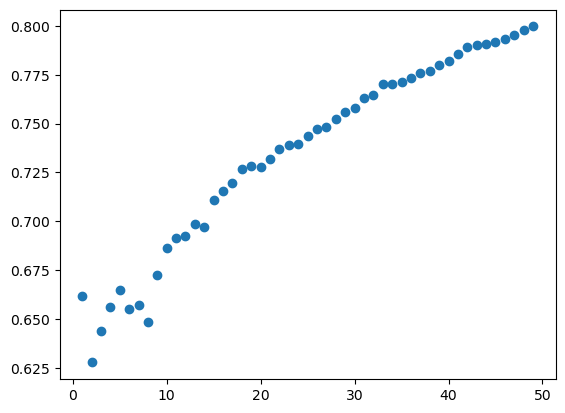

In [197]:
def visualize_mean_overlap(base_data, olap_data, n):
    means = []
    for i in range(1, n):
        overlaps = [compute_overlap(olap_data[k1],base_data[k2], i) for k1, k2 in list(zip(neims_test_spec.keys(),  nist_test_spec.keys()))]
        mean_rate = sum([x/y for x, y in overlaps])/len(overlaps)
        means.append(mean_rate)
        ##########
        #print(str(i) + ":", mean_rate)
    plt.scatter(range(1,n), means)
visualize_mean_overlap(nist_test_spec, neims_test_spec, 50)

## Enrich the samples with categories

Add to the dictionary the information about categories adapted from:  https://gitlab.unige.ch/Pierre-Marie.Allard/pybatchclassyfire/-/tree/master/notebook

In [37]:
!ls

 data			    nist_test_smiles.txt
 data_preprocessing.ipynb   play_with_smiles.ipynb
 michal_repo		    tmp
 neims_gen_analysis.ipynb  'ZINC-downloader-2D-smi (1).uri'
 nist_test_smiles.sdf


In [43]:
# get file with inchikeys sorted by nistID
os.makedirs("tmp", exist_ok=True)
with open("./tmp/neims_test_inchikeys.inch", "w") as f:
    for key in sorted(nist_test_spec.keys()):
        f.write(nist_test_spec[key]["inchikey"] + "\n")


In [ ]:
enriched_path = "tmp/classed_inchikey.csv"
test_classes = pd.read_csv(enriched_path, index_col=0)

# add classes to nist_test_spec
skeys = sorted(nist_test_spec.keys()
for index, row in test_classes.iterrows():
    assert row["InChIKey"] == nist_test_spec[skeys[index]]["inchikey"]
    nist_test_spec[key]["class"] = row["Class"]